In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [2]:
!pip install calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8121 sha256=e62783326d2a5267d45787a490f39e636fd766bf3856725b7f44e7b1372e55f9
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from calplot import calplot as clp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Reshape, Dropout, BatchNormalization, Bidirectional, MaxPooling1D
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import warnings 

import holidays

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
plt.style.use('dark_background')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
df = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv", index_col="id", parse_dates=["date"])
df.head()

date    country         store  \
id                                       
0  2017-01-01  Argentina  Kaggle Learn   
1  2017-01-01  Argentina  Kaggle Learn   
2  2017-01-01  Argentina  Kaggle Learn   
3  2017-01-01  Argentina  Kaggle Learn   
4  2017-01-01  Argentina  Kaggle Learn   

                                           product  num_sold  
id                                                            
0                Using LLMs to Improve Your Coding        63  
1                    Using LLMs to Train More LLMs        66  
2   Using LLMs to Win Friends and Influence People         9  
3       Using LLMs to Win More Kaggle Competitions        59  
4                       Using LLMs to Write Better        49

In [5]:
df.shape

(136950, 5)

# Exploratory data analysis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


In [7]:
df_aux = pd.DataFrame(index=df.columns)
df_aux["count"] = df.count()
df_aux["nunique"] = df.nunique()
df_aux["NaN"] = df.isna().sum()
df_aux

count  nunique  NaN
date      136950     1826    0
country   136950        5    0
store     136950        3    0
product   136950        5    0
num_sold  136950     1028    0

We have 136950 records but we only have 1028 uniques num_sold values, these are too little uniques values this means that we will have many values repeated.

In [8]:
df.describe()

num_sold
count  136950.000000
mean      165.522636
std       183.691575
min         2.000000
25%        46.000000
50%        98.000000
75%       184.000000
max      1380.000000

## Sales
## Sales Distribution

In [9]:
def dist_sales(df, feature=None):
    sea = sns.FacetGrid(df, row=feature, height=3, aspect=5, hue=feature)
    sea.map_dataframe(sns.histplot, x="num_sold", kde=True)
    for ax in sea.axes.flat:
        ax.grid(linestyle=":")

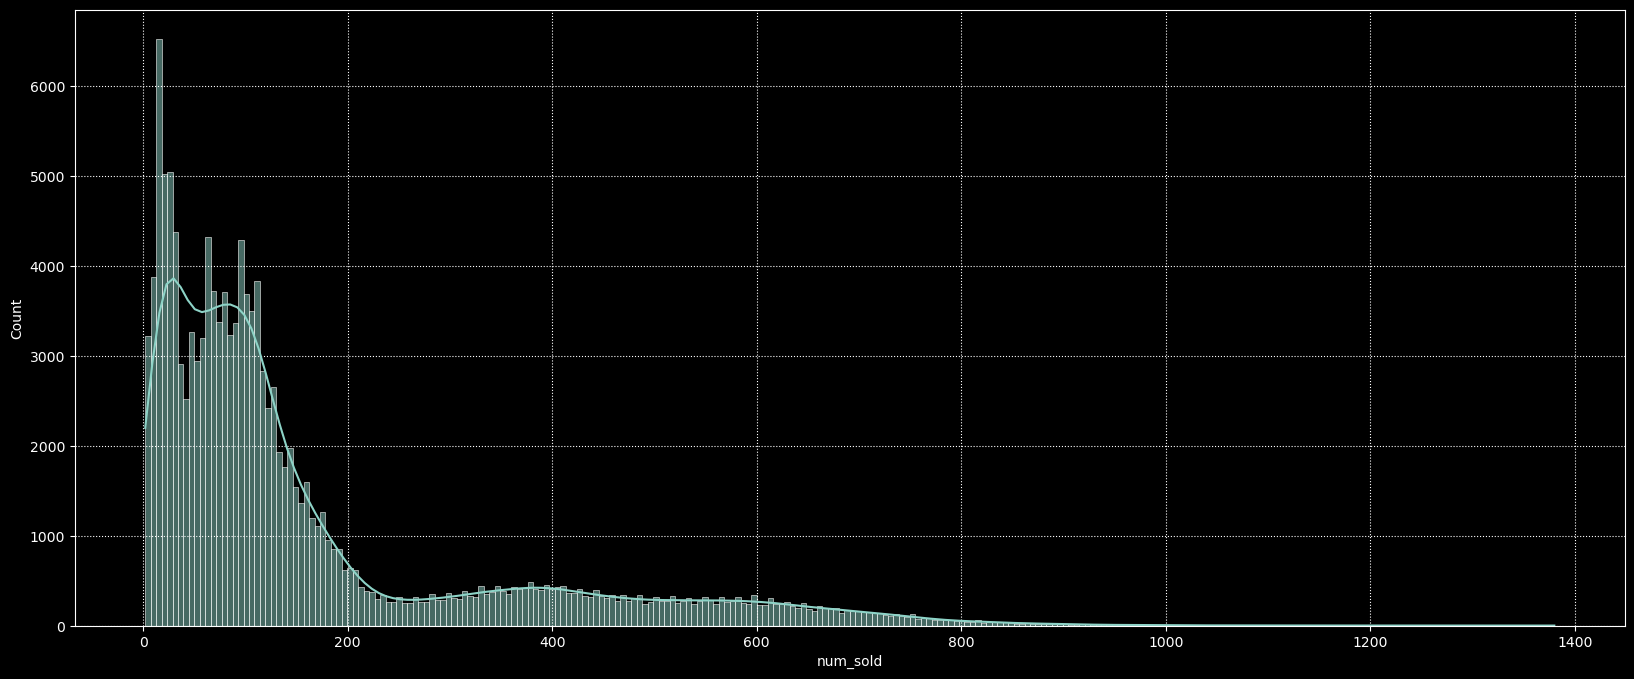

In [10]:
fig = plt.figure(figsize=(20,8))
sns.histplot(data=df, x="num_sold", kde=True)
plt.grid(linestyle=":")

We can see that the sales are skewed to the left, also we see that between 200 and 600 the sales are hold constant after this strip we can see a decrease to almost zero value. This mean that sales often are low but must exist periods where the sales are high. We will check this later with a timeline analysis.

### Sales distribution by product

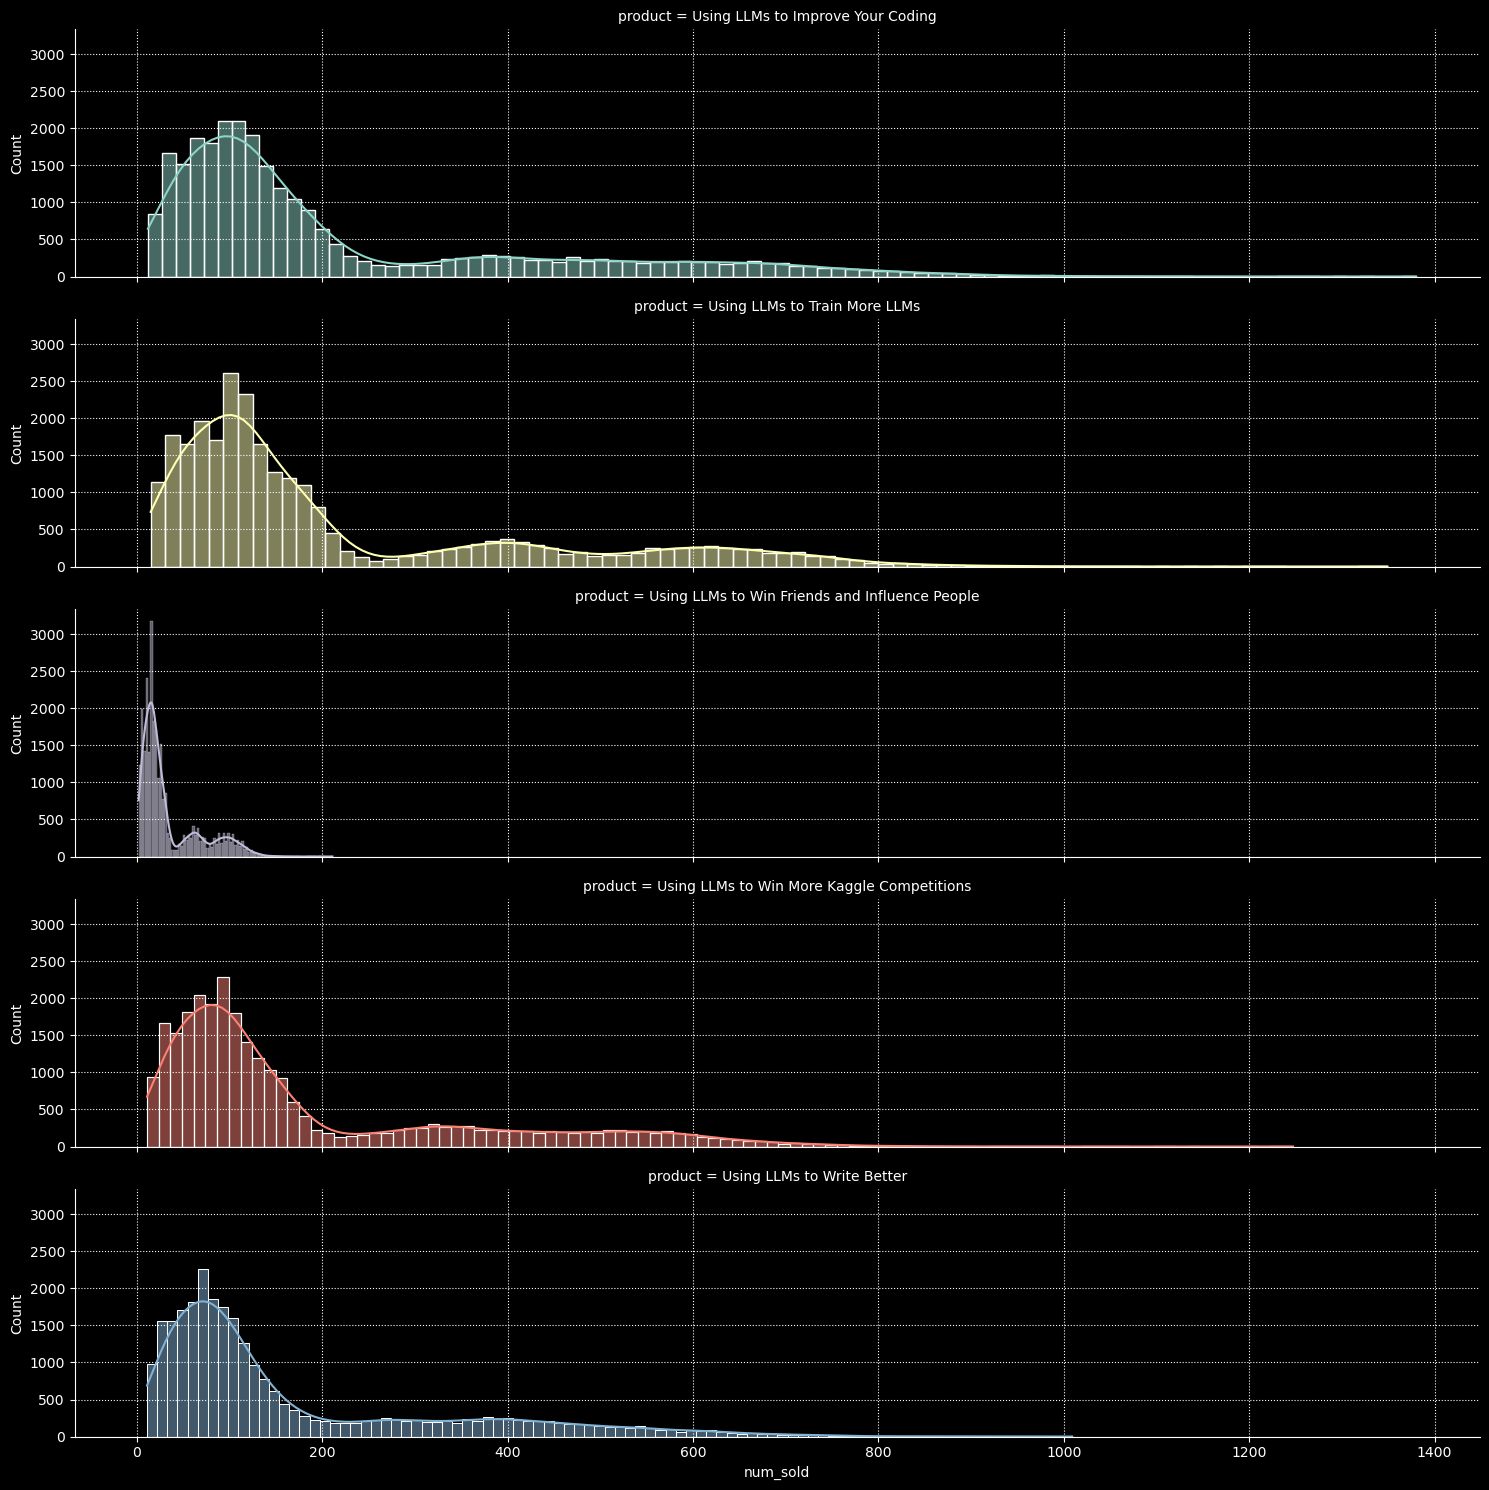

In [11]:
dist_sales(df, "product")

We can see that almost all distributions show similar characteristics except for one, which seems to be that people are not so interested in using LLMs to win friends and influence people since the sales for this product are too low.

### Sales distribution by store

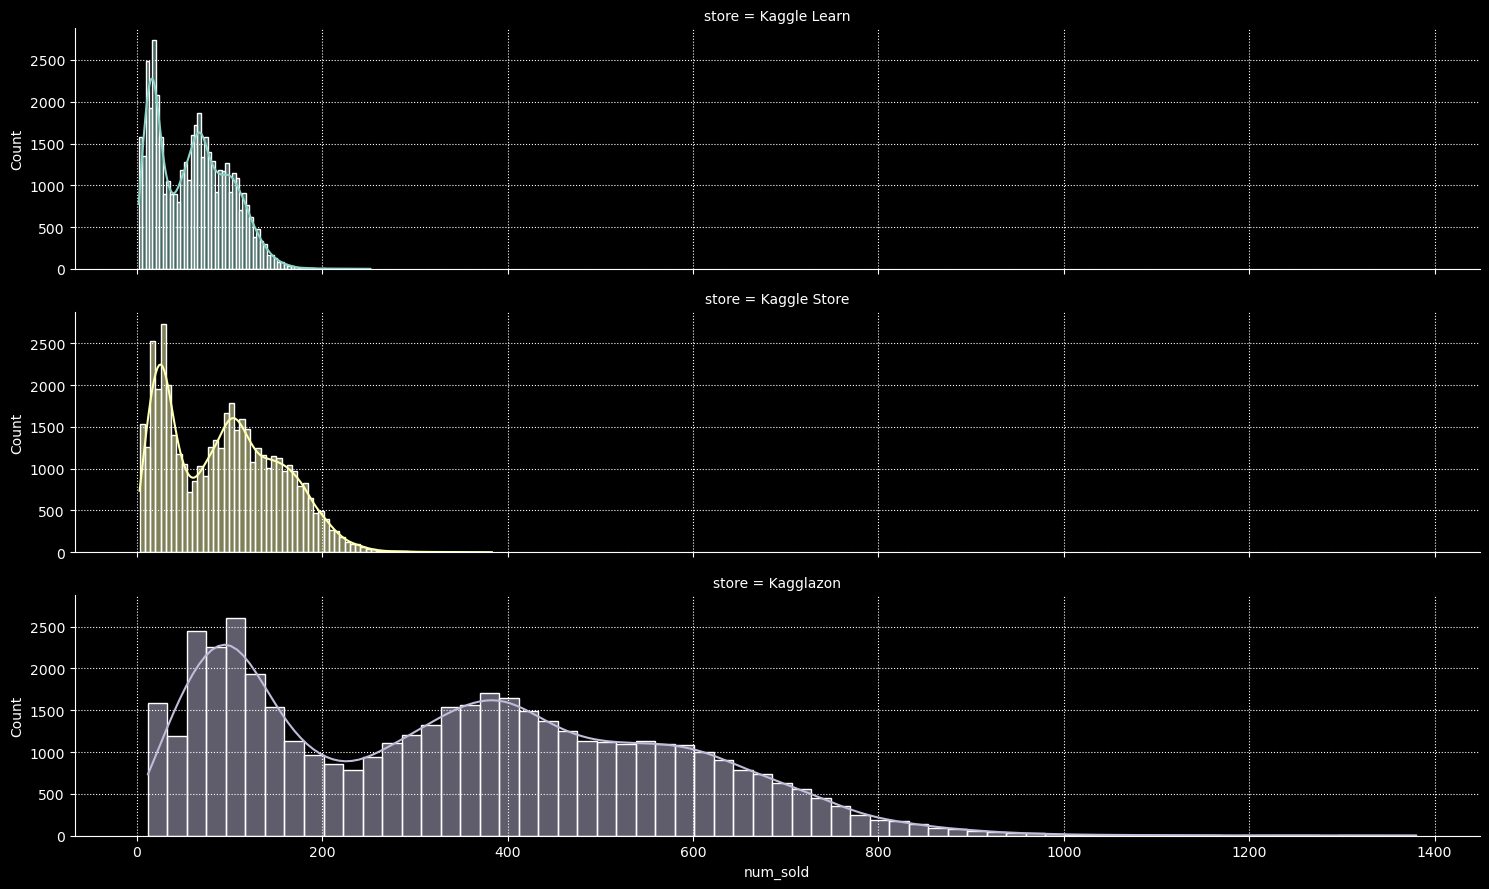

In [12]:
dist_sales(df, "store")

It's seems to be that Kagglazon is better store to sell than the rest, this store have often high sales.

### Sales distribution by country

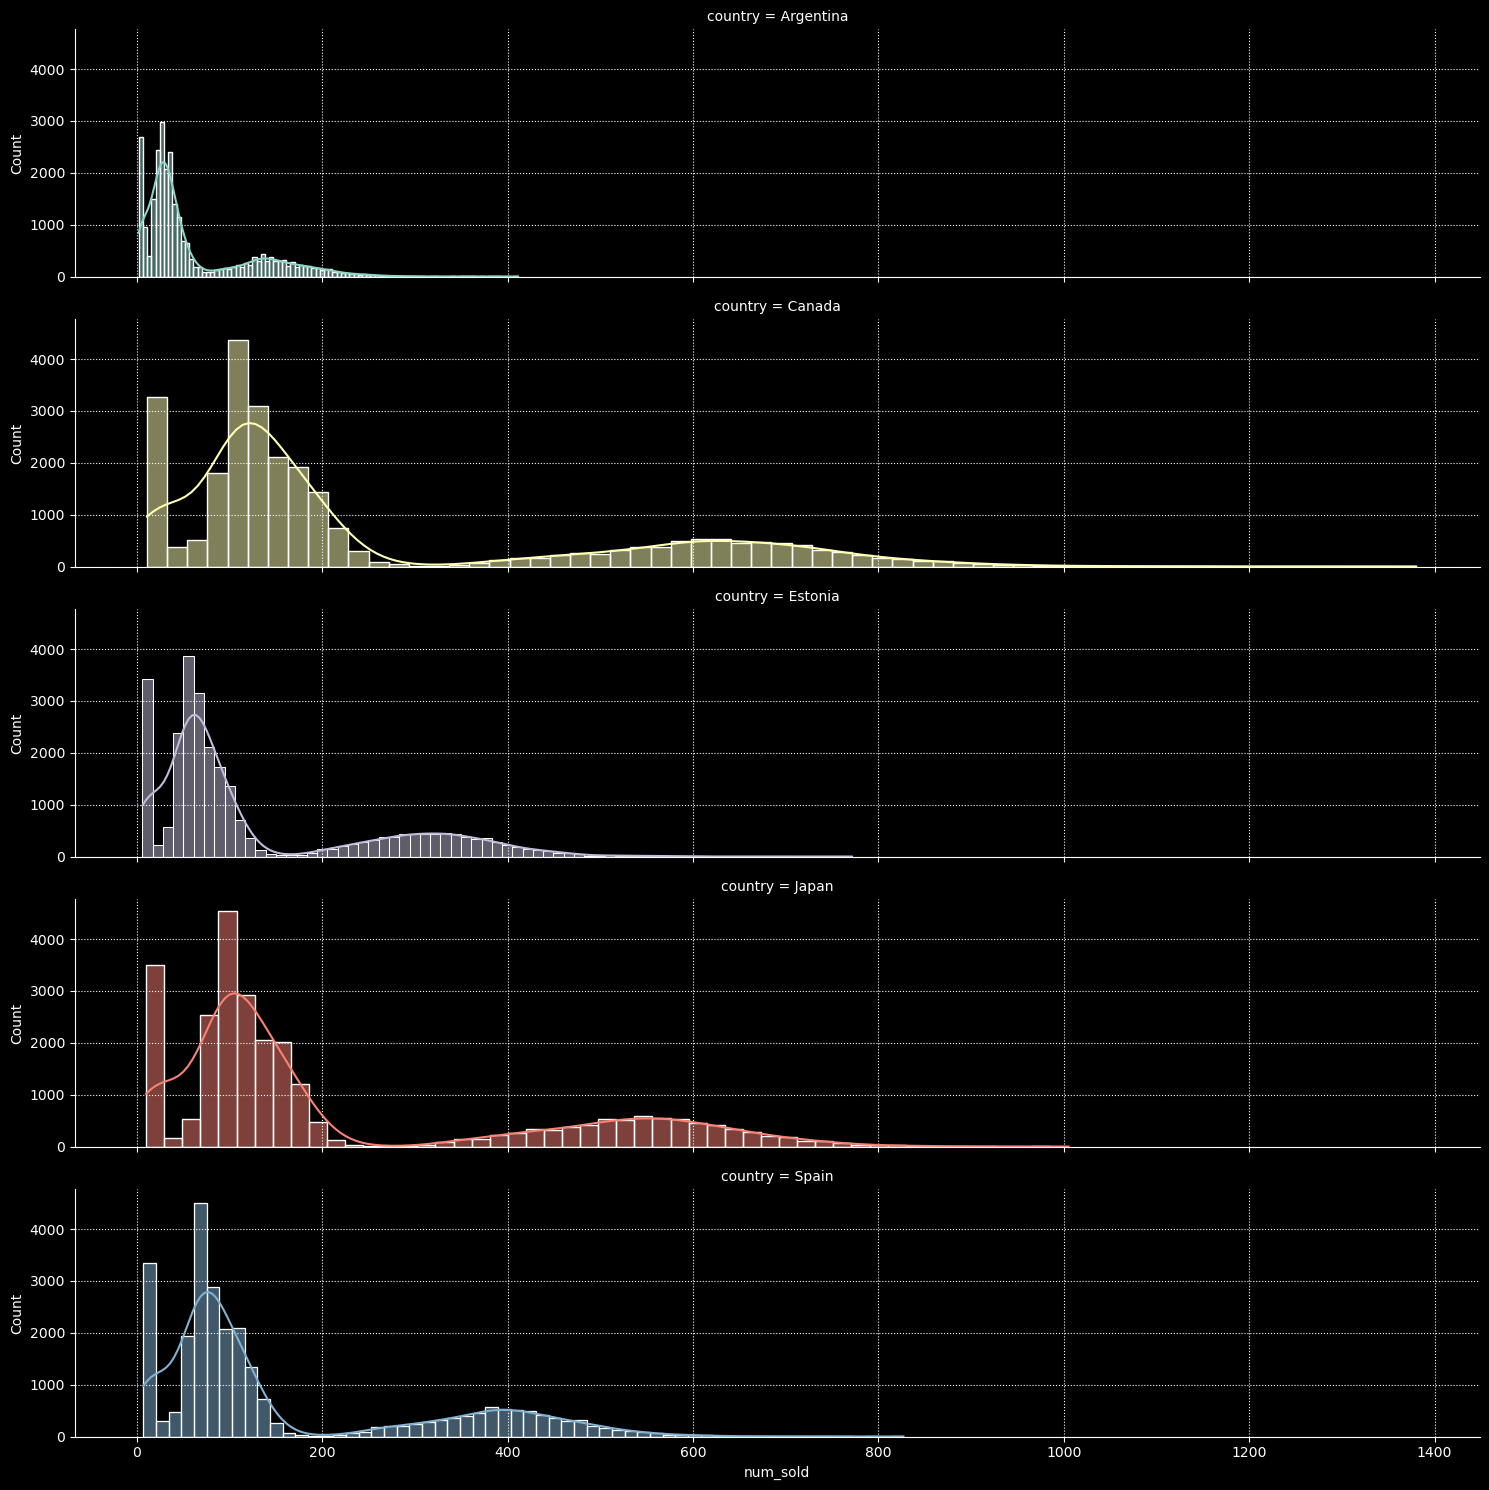

In [13]:
dist_sales(df, "country")

The countries with best sales are Canada and Japan, followed by Estonia and Span and finally there is Argentina with sales too low.

## Sales timeline and calendar heatmap

In [14]:
def timeline_sales(df, feature=None):
    fig = plt.figure(figsize=(20,8))
    sns.lineplot(data=df, x="date", y="num_sold", hue=feature, errorbar = None)
    plt.grid(linestyle=":")

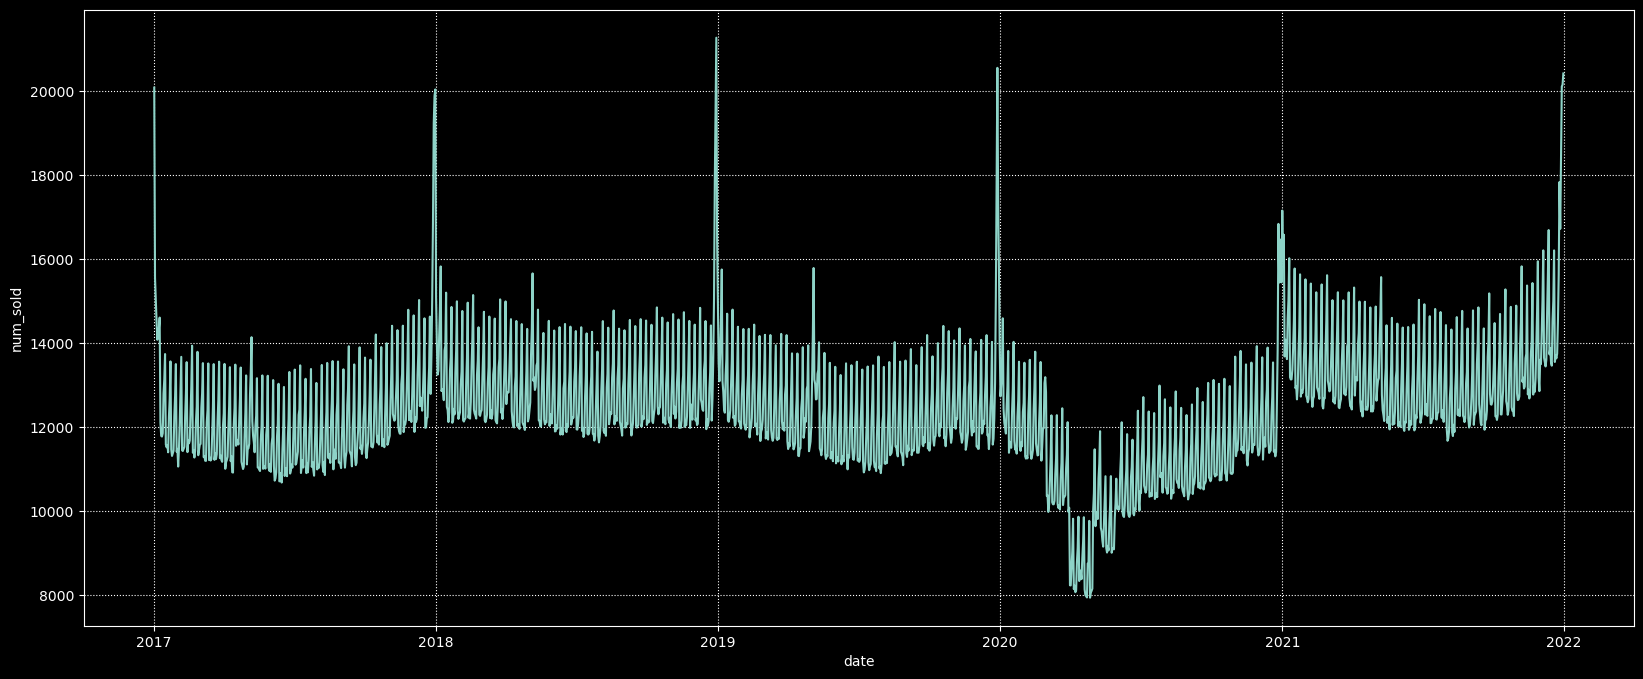

In [15]:
fig = plt.figure(figsize=(20,8))
df_aux = df.groupby(["date"]).num_sold.sum()
sns.lineplot(x=df_aux.index, y=df_aux, errorbar = None)

#sns.lineplot(x=df_aux.index, y=df_aux.rolling(7).mean().shift(-3), errorbar = None)

plt.grid(linestyle=":")

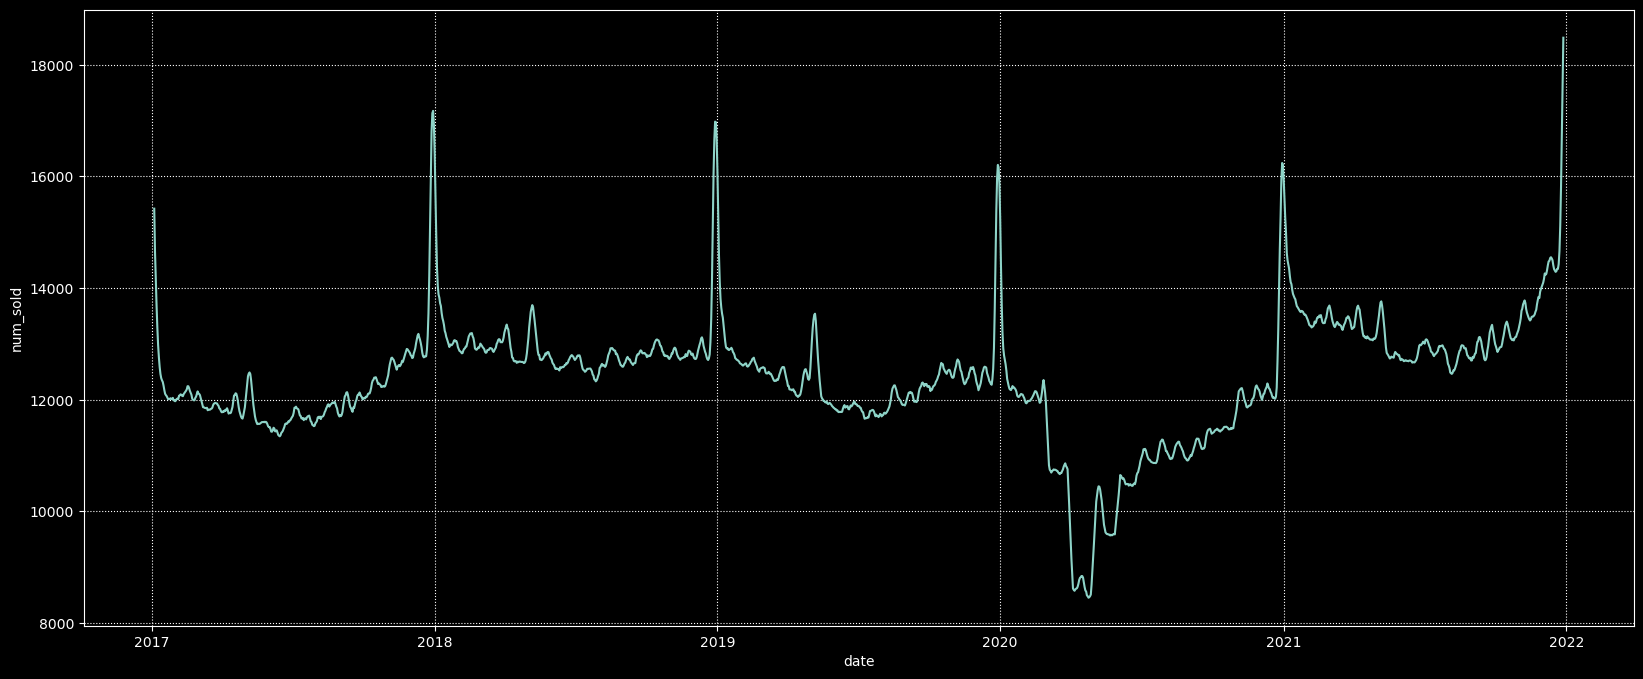

In [16]:
fig = plt.figure(figsize=(20,8))
sns.lineplot(x=df_aux.index, y=df_aux.rolling(7).mean().shift(-3), errorbar = None)

plt.grid(linestyle=":")

(<Figure size 1250x850 with 6 Axes>,
 array([<Axes: ylabel='2017'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>], dtype=object))

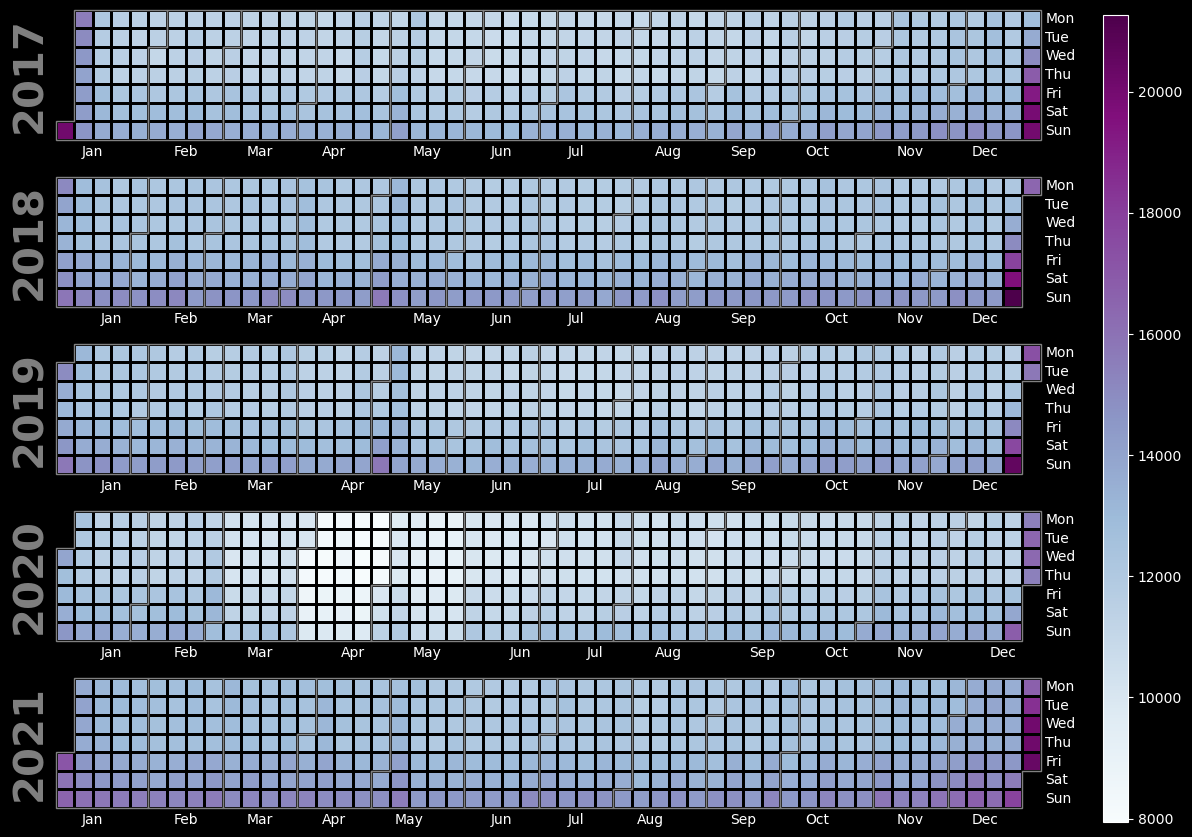

In [17]:
clp(df_aux, cmap='BuPu')

The first thing that we can see in the timeline plot is that near of end of each year and beginning of each year the sales have a maximun peak because Christmas and New Year events, Also, there seems to be a important peak in the middle of each year, maybe, around May, we will see later. In 2020 there were low sales because this was the peak year of the COVID-19 pandemic. On the other hand, we can see in the calendar heatmap that there is an increasing trend in sales as we get closer to the weekends. Let's looking for some peaks.

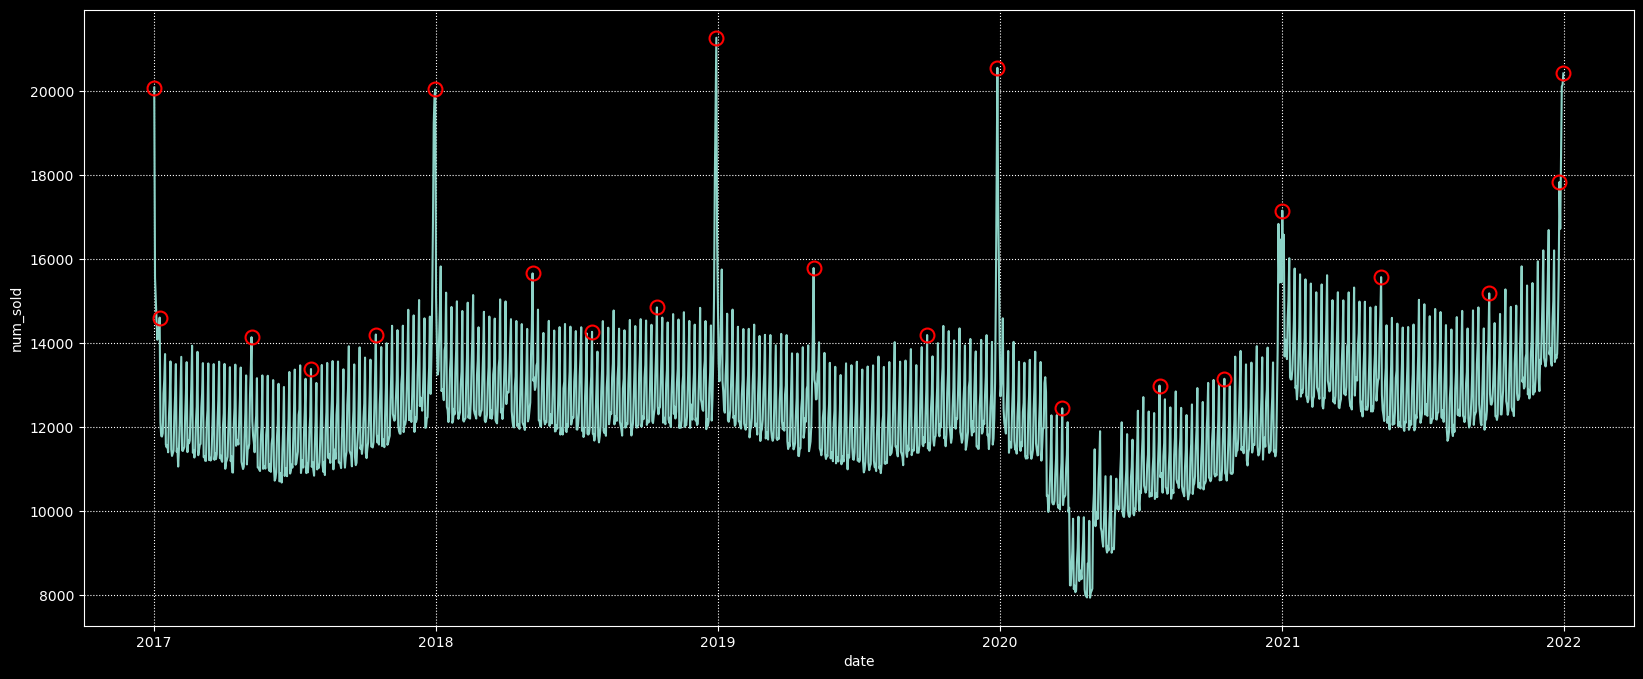

In [18]:
df_aux = df.groupby(["date"]).num_sold.sum()
peaks = np.concatenate((np.array([0]), find_peaks(df_aux, distance=75)[0], np.array([df_aux.shape[0]-1])))
dates = df.loc[df["date"].isin(df_aux.index[peaks]), "date"].values
dates_index = [i for i, date in enumerate(df["date"].unique()) if date in dates]
fig = plt.figure(figsize=(20,8))
sns.lineplot(x=df_aux.index, y=df_aux, errorbar = None, markevery=dates_index, marker = 'o', markersize=10, fillstyle='none', markeredgewidth=1.5, markeredgecolor='red')
plt.grid(linestyle=":")

In [19]:
pd.DataFrame(data={"date_with_peaks_sales": [pd.to_datetime(i).strftime("%Y-%m-%d") for i in set(dates)]}).sort_values(by="date_with_peaks_sales")

date_with_peaks_sales
0             2017-01-01
1             2017-01-08
4             2017-05-07
2             2017-07-23
3             2017-10-15
5             2017-12-31
6             2018-05-06
7             2018-07-22
8             2018-10-14
9             2018-12-30
10            2019-05-05
11            2019-09-29
16            2019-12-29
17            2020-03-22
18            2020-07-26
19            2020-10-18
13            2021-01-01
12            2021-05-09
14            2021-09-26
20            2021-12-26
15            2021-12-31

(<Figure size 1250x850 with 6 Axes>,
 array([<Axes: ylabel='2017'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>], dtype=object))

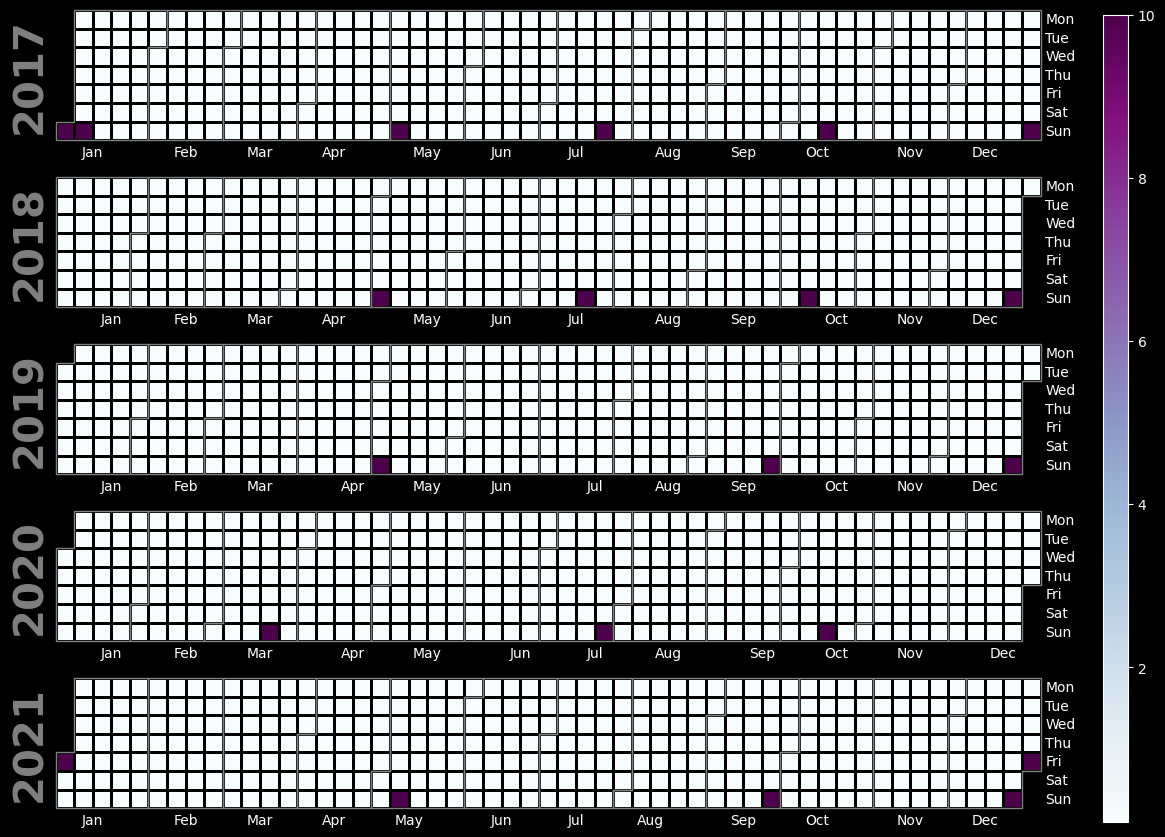

In [20]:
all_days = pd.date_range('1/1/2017', periods=365*5+1, freq='D')
peaks_days = np.array([i for i in set(dates)])
events = pd.Series(np.ones((len(all_days)))*(0.1), index=all_days)
events.iloc[events.index.isin(pd.to_datetime(peaks_days))] = 10
clp(events, cmap='BuPu')

### Sales timeline by product

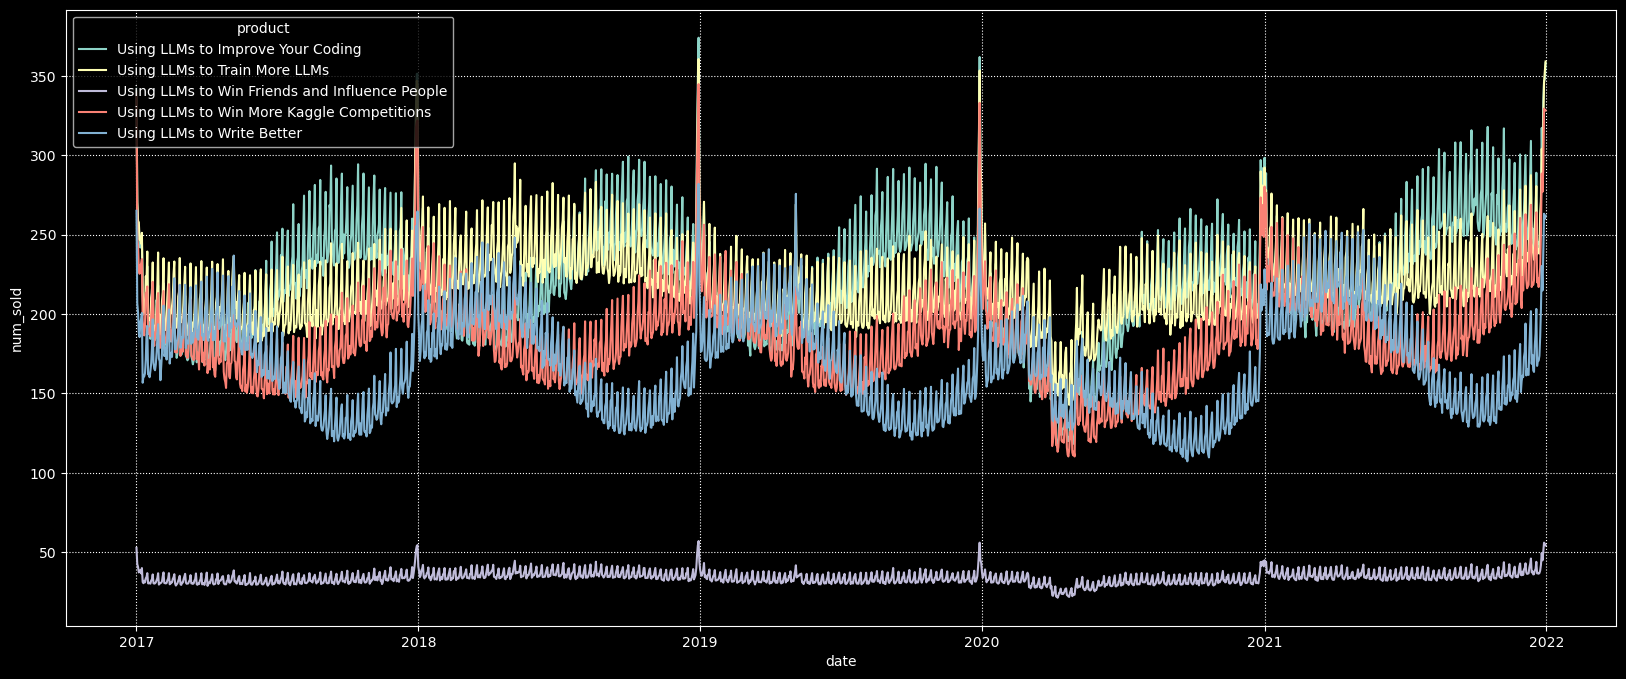

In [21]:
timeline_sales(df, "product")

We already said it before, the product "Using LLMs to Win Friends and Influence People" is the least sold. The product "Using LLMs to Write better" presents high sales in the first semester of each year and presents low sales in the second semester of each year, while that the product "Using LLMs to Improve Your Coding" presents a behavior opposite. The product "Using LLMs to Win More Kaggle Competitions" presents low sales in the middle of each year.

### Sales timeline by score

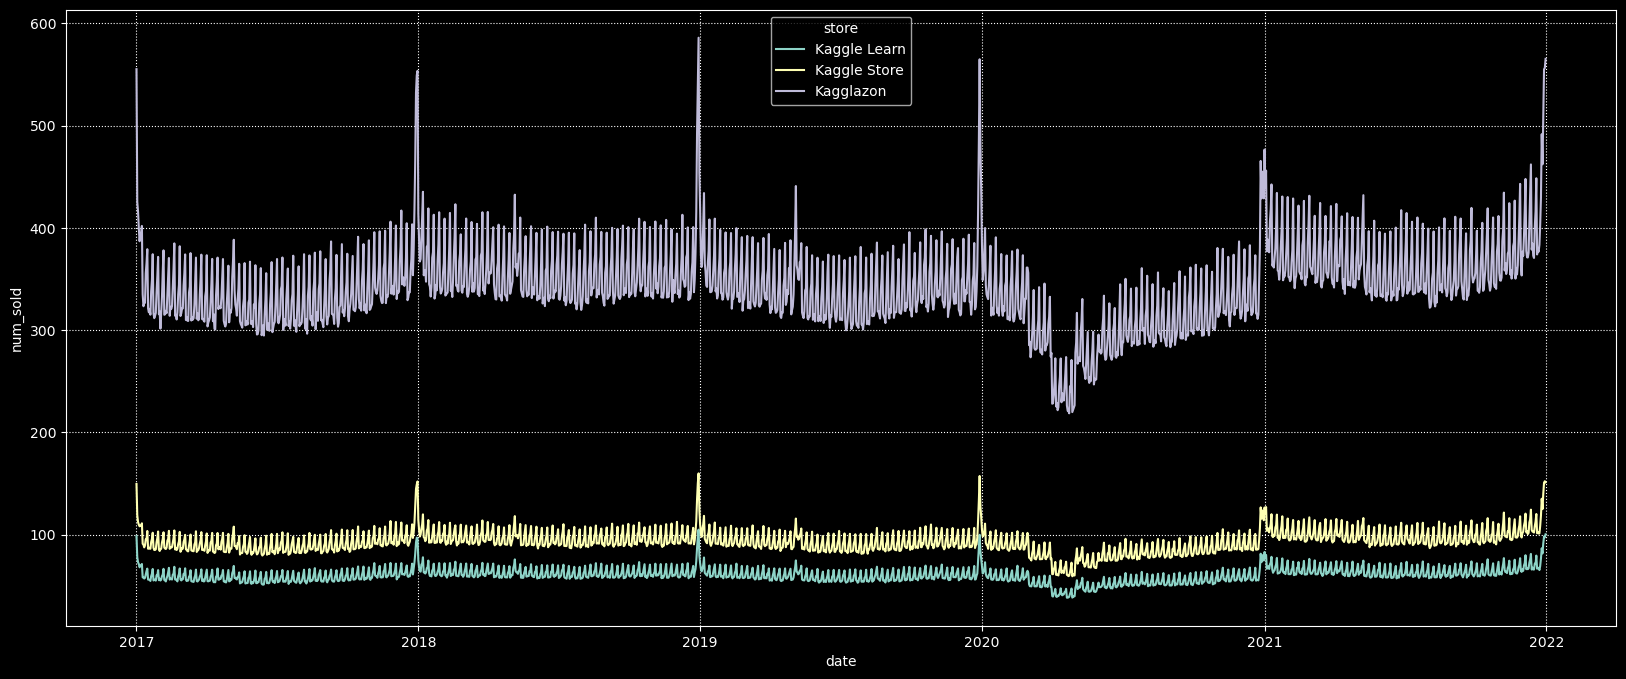

In [22]:
timeline_sales(df, "store")

Kagglazon is the store with most sales, followed by Kaggle Store and Kaggle Learn.

### Sales timeline by country

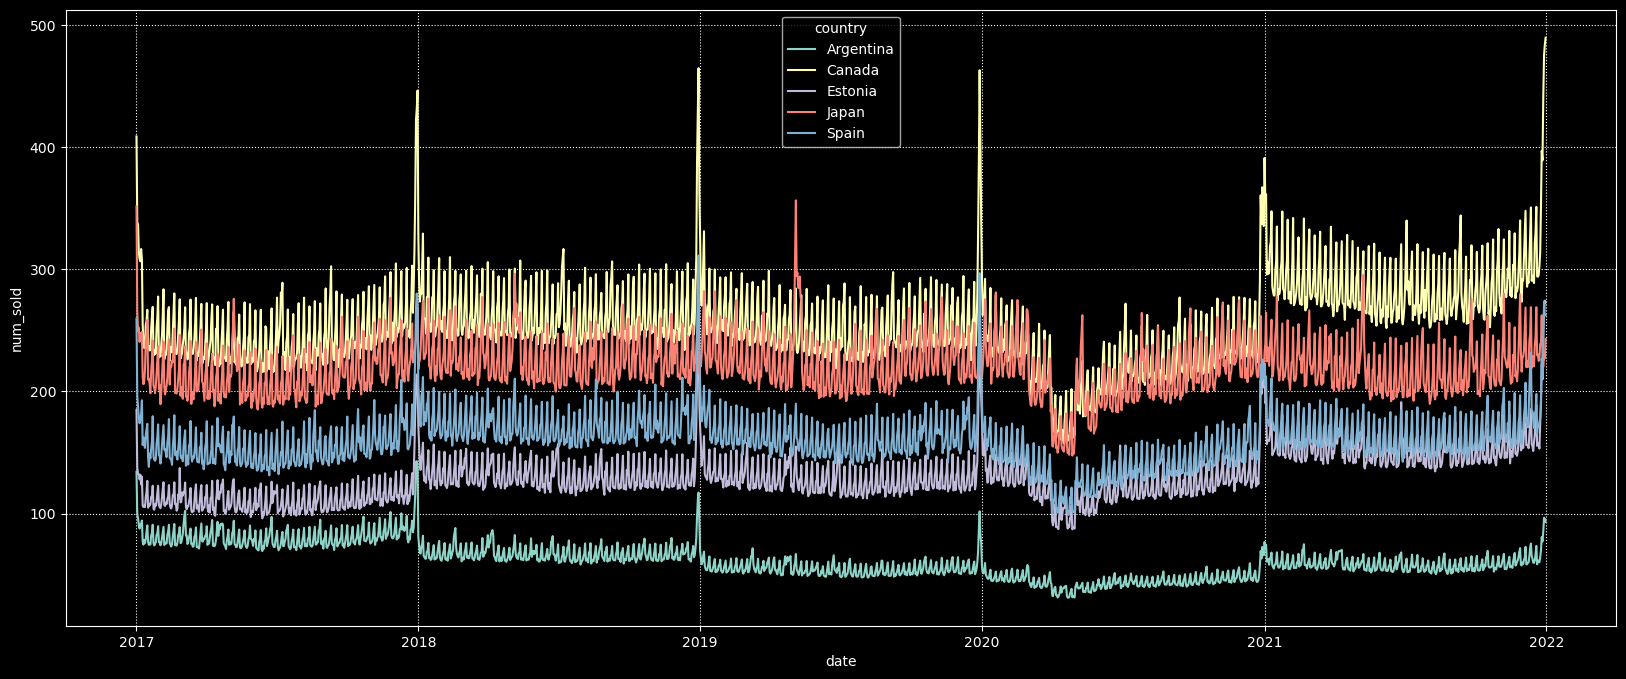

In [23]:
timeline_sales(df, "country")

Argentina got sales by year each time more low. Canada and Japan obtained similar sales in 2020 but Canada strongly increased its sales in 2021.

# Categorical Feature
# Distribution

Let's see the proportion of each categorical feature.

Text(0.5, 1.0, 'Countries in dataset')

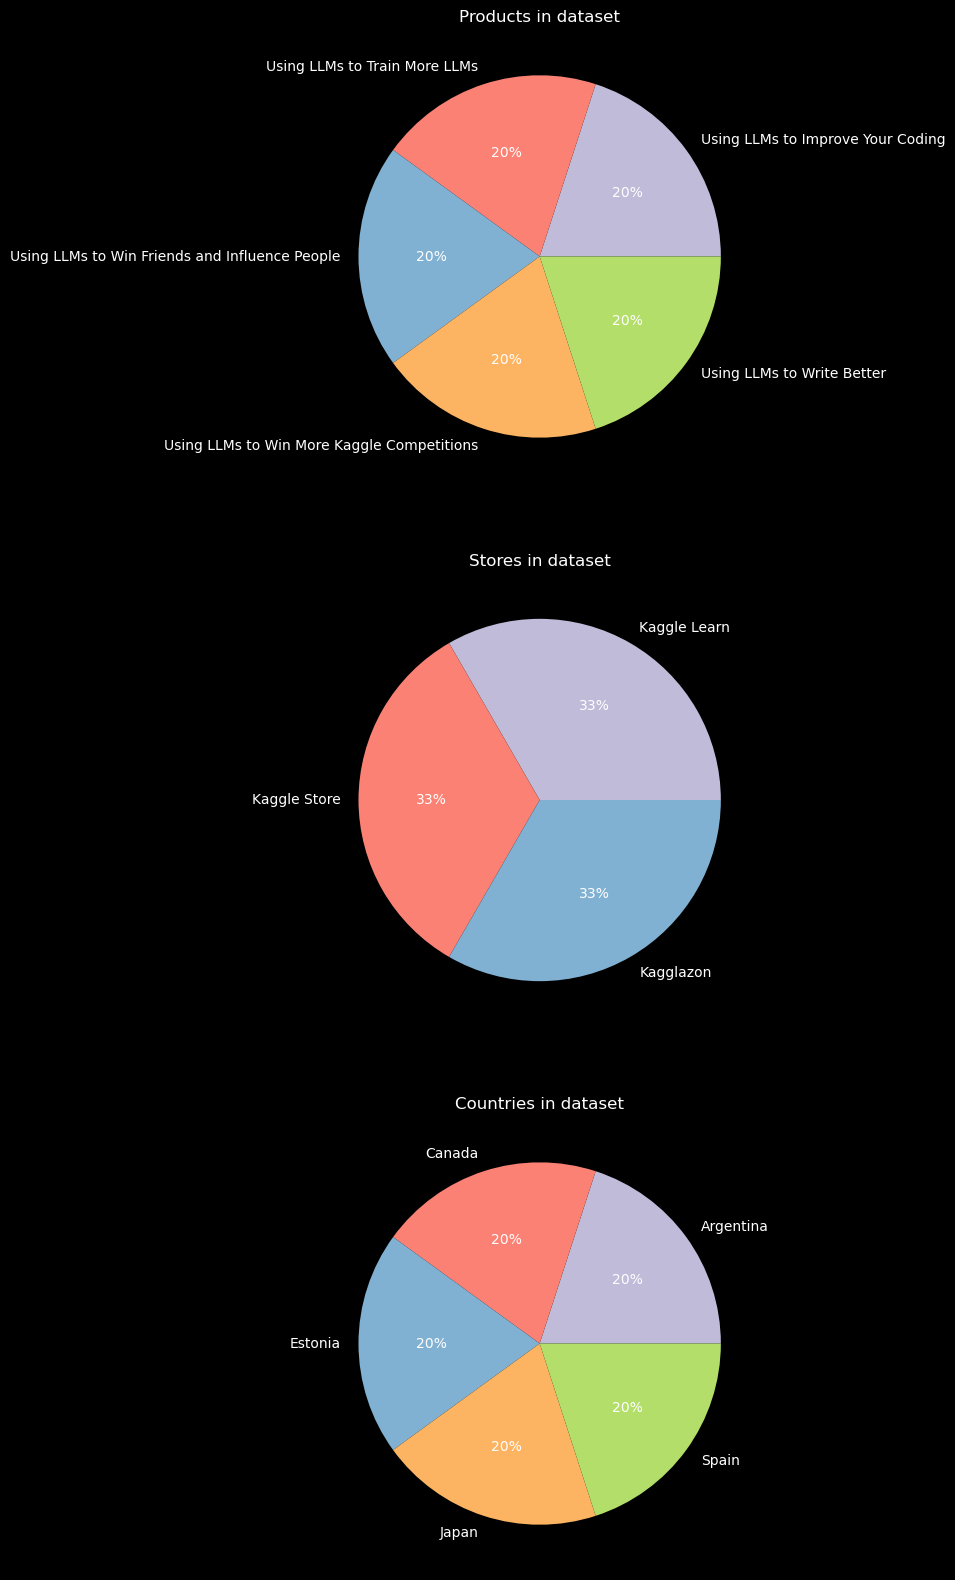

In [24]:
colors = sns.color_palette()[2:]
fig = plt.figure(figsize=(20, 20))
axs = fig.subplots(3, 1)
axs[0].pie(df["product"].value_counts(), labels = df["product"].unique(), colors = colors, autopct='%.0f%%')
axs[0].set_title("Products in dataset")

axs[1].pie(df["store"].value_counts(), labels = df["store"].unique(), colors = colors, autopct='%.0f%%')
axs[1].set_title("Stores in dataset")

axs[2].pie(df["country"].value_counts(), labels = df["country"].unique(), colors = colors, autopct='%.0f%%')
axs[2].set_title("Countries in dataset")

The dataset is perfectly balanced.

# Loading test set

In [25]:
df_test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv", parse_dates=["date"], index_col="id")
df_test

date    country         store  \
id                                           
136950 2022-01-01  Argentina  Kaggle Learn   
136951 2022-01-01  Argentina  Kaggle Learn   
136952 2022-01-01  Argentina  Kaggle Learn   
136953 2022-01-01  Argentina  Kaggle Learn   
136954 2022-01-01  Argentina  Kaggle Learn   
...           ...        ...           ...   
164320 2022-12-31      Spain     Kagglazon   
164321 2022-12-31      Spain     Kagglazon   
164322 2022-12-31      Spain     Kagglazon   
164323 2022-12-31      Spain     Kagglazon   
164324 2022-12-31      Spain     Kagglazon   

                                               product  
id                                                      
136950               Using LLMs to Improve Your Coding  
136951                   Using LLMs to Train More LLMs  
136952  Using LLMs to Win Friends and Influence People  
136953      Using LLMs to Win More Kaggle Competitions  
136954                      Using LLMs to Write Better  
...                                                ...  
164320               Using LLMs to Improve Your Coding  
164321                   Using LLMs to Train More LLMs  
164322  Using LLMs to Win Friends and Influence People  
164323      Using LLMs to Win More Kaggle Competitions  
164324                      Using LLMs to Write Better  

[27375 rows x 4 columns]

## Determinating lags

In [26]:
lags = df_test["date"].unique().shape[0]
lags

365

In [27]:
#df.drop(df[(df.date.dt.month == 2) & (df.date.dt.day == 29)].index, axis=0, inplace=True)

## Grouping by date to split in multiples time series

In [28]:
countries = df["country"].unique()
stores = df["store"].unique()
products = {name:f"product_{i}" for i, name in enumerate(df["product"].unique())}

df_byDate = pd.DataFrame(data={"date": df["date"].unique()})
label_columns = []

for country in countries:
    for store in stores:
        for product in products:
            num_sold = df.loc[(df["country"] == country) & (df["store"] == store) & (df["product"] == product), "num_sold"]
            col_name = country  + " " + store + " " + products[product]
            label_columns.append(col_name)
            df_byDate[col_name] = num_sold.values
            
df_byDate

date  Argentina Kaggle Learn product_0  \
0    2017-01-01                                63   
1    2017-01-02                                51   
2    2017-01-03                                44   
3    2017-01-04                                44   
4    2017-01-05                                40   
...         ...                               ...   
1821 2021-12-27                                41   
1822 2021-12-28                                38   
1823 2021-12-29                                46   
1824 2021-12-30                                45   
1825 2021-12-31                                44   

      Argentina Kaggle Learn product_1  Argentina Kaggle Learn product_2  \
0                                   66                                 9   
1                                   47                                 7   
2                                   45                                 7   
3                                   42                                 7   
4                                   46                                 6   
...                                ...                               ...   
1821                                34                                 5   
1822                                44                                 6   
1823                                43                                 7   
1824                                44                                 7   
1825                                47                                 6   

      Argentina Kaggle Learn product_3  Argentina Kaggle Learn product_4  \
0                                   59                                49   
1                                   43                                35   
2                                   41                                37   
3                                   40                                32   
4                                   39                                32   
...                                ...                               ...   
1821                                33                                28   
1822                                37                                30   
1823                                43                                37   
1824                                44                                34   
1825                                43                                32   

      Argentina Kaggle Store product_0  Argentina Kaggle Store product_1  \
0                                   88                                98   
1                                   74                                77   
2                                   64                                68   
3                                   72                                66   
4                                   66                                61   
...                                ...                               ...   
1821                                54                                60   
1822                                59                                70   
1823                                69                                70   
1824                                74                                72   
1825                                63                                73   

      Argentina Kaggle Store product_2  Argentina Kaggle Store product_3  ...  \
0                                   14                                83  ...   
1                                   11                                70  ...   
2                                   11                                67  ...   
3                                   10                                64  ...   
4                                   10                                64  ...   
...                                ...                               ...  ...   
1821                                 9                              

# Analyzing for seasonality

In [29]:
def ADF2pd(df, label_columns, columns=None, transform=False, n=1):
    cols = ["Time Series", "ADF Statistic", "p_value", "Rejection_H0", "Conclusion"]
    df_ADF = pd.DataFrame(columns=cols)
    
    for col in label_columns:
        timeseries = df.loc[:, col]
        
        if transform == True:
            timeseries = np.diff(timeseries, n=n)
        
        ADF_result = adfuller(timeseries)
        rejectionH0 = "Yes" if ADF_result[1] < 0.05 else "No"
        conclusion = "Time series is stationary" if ADF_result[1] < 0.05 else "Time series is not stationary"
        
        values = [col] + [ADF_result[0], ADF_result[1], rejectionH0, conclusion]
        
        row = pd.DataFrame(data={k:[v] for (k, v) in zip(cols, values)})
        df_ADF = pd.concat([df_ADF, row], ignore_index=True)
    return df_ADF
            
adf = ADF2pd(df_byDate, label_columns)
adf

Time Series  ADF Statistic   p_value Rejection_H0  \
0   Argentina Kaggle Learn product_0      -1.661765  0.450912           No   
1   Argentina Kaggle Learn product_1      -1.776544  0.392168           No   
2   Argentina Kaggle Learn product_2      -2.003774  0.284921           No   
3   Argentina Kaggle Learn product_3      -1.949714  0.309047           No   
4   Argentina Kaggle Learn product_4      -1.972129  0.298926           No   
5   Argentina Kaggle Store product_0      -1.604019  0.481574           No   
6   Argentina Kaggle Store product_1      -1.790581  0.385148           No   
7   Argentina Kaggle Store product_2      -1.947201  0.310192           No   
8   Argentina Kaggle Store product_3      -1.965915  0.301715           No   
9   Argentina Kaggle Store product_4      -1.905270  0.329586           No   
10     Argentina Kagglazon product_0      -1.687016  0.437814           No   
11     Argentina Kagglazon product_1      -1.911880  0.326493           No   
12     Argentina Kagglazon product_2      -1.857293  0.352410           No   
13     Argentina Kagglazon product_3      -1.909001  0.327838           No   
14     Argentina Kagglazon product_4      -2.044731  0.267311           No   
15     Canada Kaggle Learn product_0      -1.335506  0.612776           No   
16     Canada Kaggle Learn product_1      -1.119276  0.707324           No   
17     Canada Kaggle Learn product_2      -1.181021  0.681706           No   
18     Canada Kaggle Learn product_3      -0.290159  0.926887           No   
19     Canada Kaggle Learn product_4      -1.732003  0.414704           No   
20     Canada Kaggle Store product_0      -1.083680  0.721536           No   
21     Canada Kaggle Store product_1      -1.394290  0.585011           No   
22     Canada Kaggle Store product_2      -1.430959  0.567347           No   
23     Canada Kaggle Store product_3      -0.517739  0.888508           No   
24     Canada Kaggle Store product_4      -1.617622  0.473976           No   
25        Canada Kagglazon product_0      -1.091458  0.718466           No   
26        Canada Kagglazon product_1      -1.020780  0.745610           No   
27        Canada Kagglazon product_2      -1.505385  0.530846           No   
28        Canada Kagglazon product_3      -0.538357  0.884312           No   
29        Canada Kagglazon product_4      -1.747155  0.406995           No   
30    Estonia Kaggle Learn product_0      -0.745612  0.834579           No   
31    Estonia Kaggle Learn product_1      -0.714552  0.842944           No   
32    Estonia Kaggle Learn product_2      -0.961249  0.767134           No   
33    Estonia Kaggle Learn product_3      -0.369908  0.915003           No   
34    Estonia Kaggle Learn product_4      -1.635883  0.464413           No   
35    Estonia Kaggle Store product_0      -0.792100  0.821431           No   
36    Estonia Kaggle Store product_1      -1.051057  0.734190           No   
37    Estonia Kaggle Store product_2      -1.017734  0.746741           No   
38    Estonia Kaggle Store product_3      -0.327903  0.921458           No   
39    Estonia Kaggle Store product_4      -1.693706  0.434358           No   
40       Estonia Kagglazon product_0      -0.988492  0.757438           No   
41       Estonia Kagglazon product_1      -1.047000  0.735739           No   
42       Estonia Kagglazon product_2      -1.006505  0.750884           No   
43       Estonia Kagglazon product_3      -0.212623  0.937000           No   
44       Estonia Kagglazon product_4      -1.597505  0.484847           No   
45      Japan Kaggle Learn product_0      -2.456865  0.126325           No   
46      Japan Kaggle Learn product_1      -4.329679  0.000394          Yes   
47      Japan Kaggle Learn product_2      -4.828799  0.000048          Yes   
48      Japan Kaggle Learn product_3      -2.746348  0.066356           No   
49      Japan Kaggle Learn product_4      -2.529146  0.108543           No   
50      Japan Kaggle Store product_0      -2.65

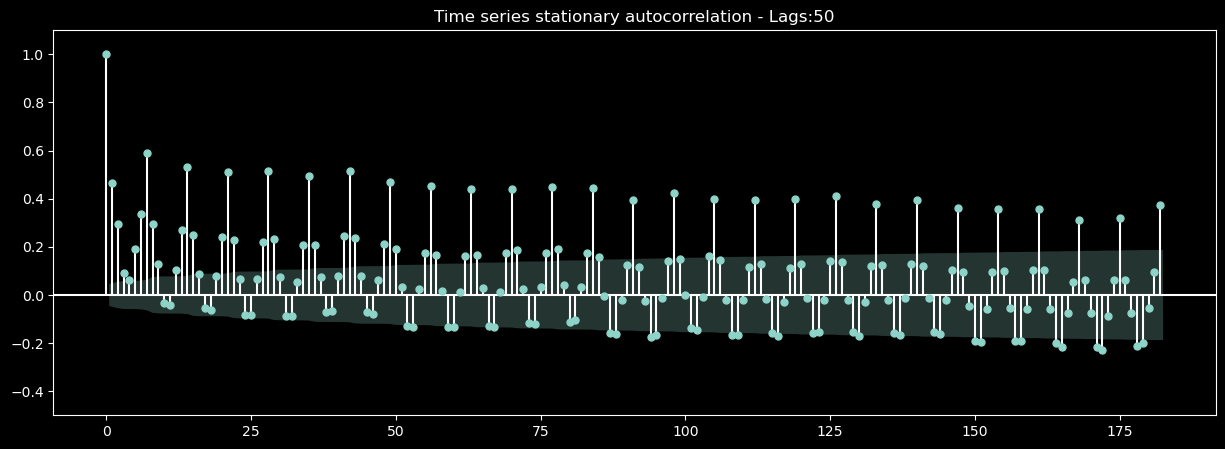

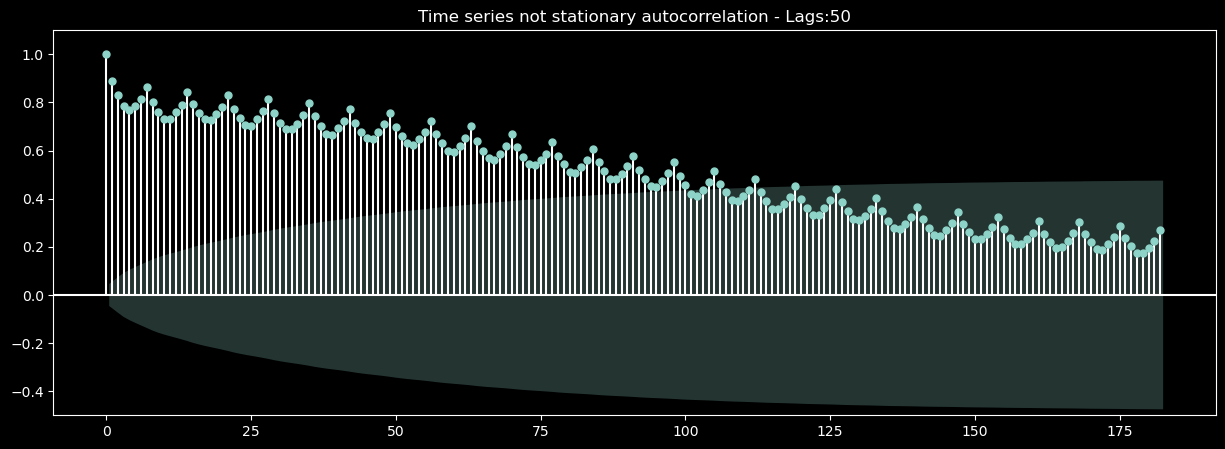

In [30]:
for i, key in enumerate([adf.loc[47, "Time Series"], adf.loc[0, "Time Series"]]):
    timeseries = df_byDate.loc[:, key]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_acf(timeseries, lags=lags//2, ax=ax)
    
    title = "stationary" if i == 0 else "not stationary"
    ax.set_ylim((-0.5, 1.1))
    ax.set_title(f"Time series {title} autocorrelation - Lags:50")

## Applying a first-order differencing and test for stationarity

In [31]:
adf = ADF2pd(df_byDate, label_columns, transform=True)
adf

Time Series  ADF Statistic       p_value  \
0   Argentina Kaggle Learn product_0     -11.380655  8.527754e-21   
1   Argentina Kaggle Learn product_1     -11.985026  3.629992e-22   
2   Argentina Kaggle Learn product_2     -12.597494  1.765666e-23   
3   Argentina Kaggle Learn product_3     -11.009278  6.385974e-20   
4   Argentina Kaggle Learn product_4     -11.062348  4.774528e-20   
5   Argentina Kaggle Store product_0     -12.000257  3.359487e-22   
6   Argentina Kaggle Store product_1     -12.700520  1.082442e-23   
7   Argentina Kaggle Store product_2     -12.888693  4.496561e-24   
8   Argentina Kaggle Store product_3     -11.940498  4.555115e-22   
9   Argentina Kaggle Store product_4     -11.122538  3.437295e-20   
10     Argentina Kagglazon product_0     -11.478461  5.062758e-21   
11     Argentina Kagglazon product_1     -12.139198  1.666104e-22   
12     Argentina Kagglazon product_2     -12.205726  1.194851e-22   
13     Argentina Kagglazon product_3     -11.779125  1.045070e-21   
14     Argentina Kagglazon product_4     -10.894969  1.198644e-19   
15     Canada Kaggle Learn product_0     -11.106253  3.756412e-20   
16     Canada Kaggle Learn product_1     -11.252398  1.699303e-20   
17     Canada Kaggle Learn product_2     -11.566067  3.184197e-21   
18     Canada Kaggle Learn product_3      -9.725690  9.287804e-17   
19     Canada Kaggle Learn product_4      -8.835231  1.726357e-14   
20     Canada Kaggle Store product_0     -10.782543  2.236095e-19   
21     Canada Kaggle Store product_1     -11.431289  6.507197e-21   
22     Canada Kaggle Store product_2     -10.441178  1.520607e-18   
23     Canada Kaggle Store product_3     -10.703021  3.484070e-19   
24     Canada Kaggle Store product_4      -9.477034  3.964108e-16   
25        Canada Kagglazon product_0     -10.767158  2.436045e-19   
26        Canada Kagglazon product_1     -11.278684  1.474607e-20   
27        Canada Kagglazon product_2     -11.726841  1.371150e-21   
28        Canada Kagglazon product_3      -9.929208  2.852548e-17   
29        Canada Kagglazon product_4      -9.752511  7.946399e-17   
30    Estonia Kaggle Learn product_0     -11.872155  6.465555e-22   
31    Estonia Kaggle Learn product_1     -12.545743  2.262532e-23   
32    Estonia Kaggle Learn product_2     -11.333064  1.100571e-20   
33    Estonia Kaggle Learn product_3     -11.737057  1.300164e-21   
34    Estonia Kaggle Learn product_4      -9.958852  2.403439e-17   
35    Estonia Kaggle Store product_0     -11.420989  6.874602e-21   
36    Estonia Kaggle Store product_1     -11.720088  1.420229e-21   
37    Estonia Kaggle Store product_2     -11.468187  5.346819e-21   
38    Estonia Kaggle Store product_3     -11.069395  4.594004e-20   
39    Estonia Kaggle Store product_4      -9.876928  3.860330e-17   
40       Estonia Kagglazon product_0     -11.166292  2.709127e-20   
41       Estonia Kagglazon product_1     -11.676623  1.781796e-21   
42       Estonia Kagglazon product_2     -11.737480  1.297308e-21   
43       Estonia Kagglazon product_3     -10.795120  2.085009e-19   
44       Estonia Kagglazon product_4      -9.437622  4.993013e-16   
45      Japan Kaggle Learn product_0     -13.414850  4.302250e-25   
46      Japan Kaggle Learn product_1     -12.738812  9.037918e-24   
47      Japan Kaggle Learn product_2     -12.432223  3.917324e-23   
48      Japan Kaggle Learn product_3     -11.804736  9.153041e-22   
49      Japan Kaggle Learn product_4     -10.469036  1.298771e-18   
50      Japan Kaggle Store product_0     -11.170371  2.649762e-20   
51      Japan Kaggle Store product_1     -12.729140  9.458483e-24   
52      Japan Kaggle Store product_2     -13.153986  1.348972e-24   
53      Japan Kaggle Store product_3     -11.969541  3.927778e-22   
54      Japan Kaggle Store product_4     -10.548385  8.298130e-19   
55         Japan Kagglazon product_0     -11.309776  1.247294e-20   
56         Japan Kagglazon product_1     -12.983659  2.908417e-24   
57         Japan Kaggla

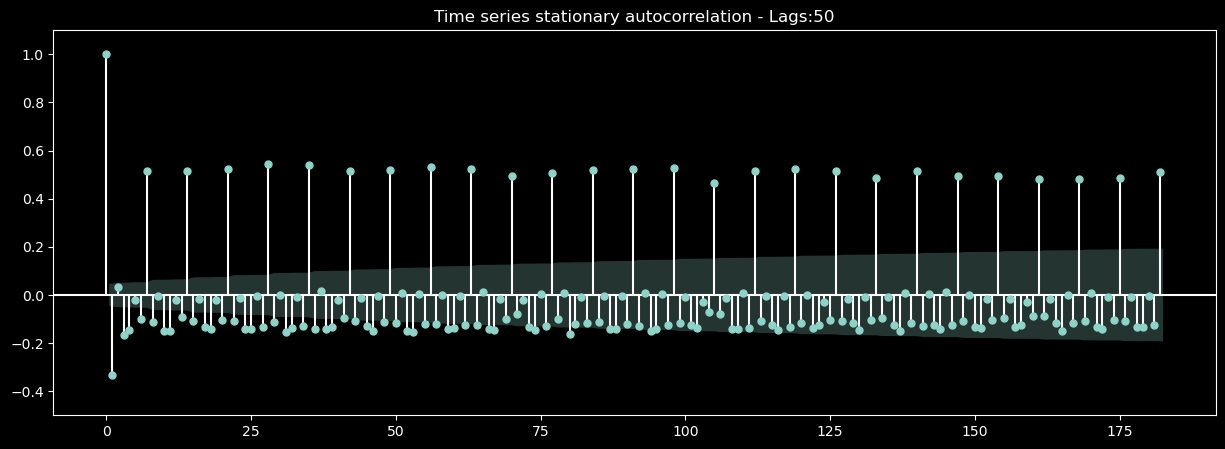

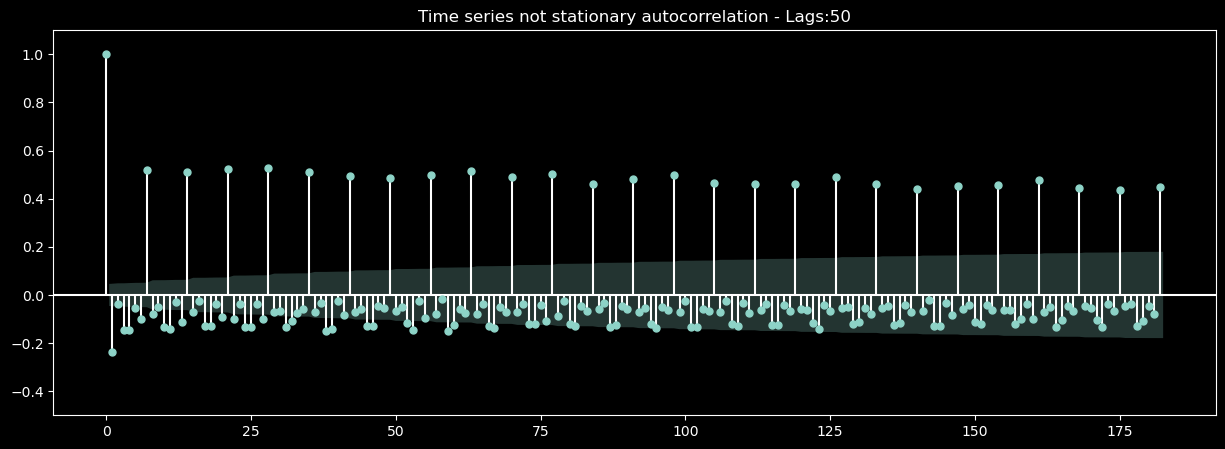

In [32]:
for i, key in enumerate([adf.loc[47, "Time Series"], adf.loc[0, "Time Series"]]):
    timeseries = df_byDate.loc[:, key]
    timeseries = np.diff(timeseries, n=1)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_acf(timeseries, lags=lags//2, ax=ax)
    
    title = "stationary" if i == 0 else "not stationary"
    ax.set_ylim((-0.5, 1.1))
    ax.set_title(f"Time series {title} autocorrelation - Lags:50")

# Feature engineering

In [33]:
def get_holidays(country, start, end):
    holiday_days = holidays.CountryHoliday(country)
    date_range = pd.date_range(start, end)
    return [date for date in date_range if date in holiday_days]

In [34]:
df_byDate["year"] = df_byDate["date"].dt.year
df_byDate["month"] = df_byDate["date"].dt.month
df_byDate["day"] = df_byDate["date"].dt.day
df_byDate["week"] = df_byDate["date"].dt.dayofweek
df_byDate["dayofweek"] = df_byDate["date"].dt.dayofweek
df_byDate["dayofyear"] = df_byDate["date"].dt.dayofyear
df_byDate["quarter"] = df_byDate["date"].dt.dayofweek
df_byDate["is_weekend"] = df_byDate["date"].dt.dayofweek > 4

for country in countries:
    df_byDate[country+" holiday"] = False
    df_byDate.loc[(df_byDate["date"].isin(get_holidays(country, df_byDate["date"].min(), df_byDate["date"].max()))), country+" holiday"] = True
    
df_byDate

date  Argentina Kaggle Learn product_0  \
0    2017-01-01                                63   
1    2017-01-02                                51   
2    2017-01-03                                44   
3    2017-01-04                                44   
4    2017-01-05                                40   
...         ...                               ...   
1821 2021-12-27                                41   
1822 2021-12-28                                38   
1823 2021-12-29                                46   
1824 2021-12-30                                45   
1825 2021-12-31                                44   

      Argentina Kaggle Learn product_1  Argentina Kaggle Learn product_2  \
0                                   66                                 9   
1                                   47                                 7   
2                                   45                                 7   
3                                   42                                 7   
4                                   46                                 6   
...                                ...                               ...   
1821                                34                                 5   
1822                                44                                 6   
1823                                43                                 7   
1824                                44                                 7   
1825                                47                                 6   

      Argentina Kaggle Learn product_3  Argentina Kaggle Learn product_4  \
0                                   59                                49   
1                                   43                                35   
2                                   41                                37   
3                                   40                                32   
4                                   39                                32   
...                                ...                               ...   
1821                                33                                28   
1822                                37                                30   
1823                                43                                37   
1824                                44                                34   
1825                                43                                32   

      Argentina Kaggle Store product_0  Argentina Kaggle Store product_1  \
0                                   88                                98   
1                                   74                                77   
2                                   64                                68   
3                                   72                                66   
4                                   66                                61   
...                                ...                               ...   
1821                                54                                60   
1822                                59                                70   
1823                                69                                70   
1824                                74                                72   
1825                                63                                73   

      Argentina Kaggle Store product_2  Argentina Kaggle Store product_3  ...  \
0                                   14                                83  ...   
1                                   11                                70  ...   
2                                   11                                67  ...   
3                                   10                                64  ...   
4                                   10                                64  ...   
...                                ...                               ...  ...   
1821                                 9                              

# Splitting into training, validation, and testing sets

In [35]:
test_index = df_byDate.loc[df_byDate["date"].dt.year == 2021].index.tolist()
test_df = df_byDate.loc[[test_index[0]-1] + test_index].drop(["date"], axis=1)

val_index = df_byDate.loc[df_byDate["date"].dt.year == 2020].index.tolist()
val_df = df_byDate.loc[[val_index[0]-1] + val_index].drop(["date"], axis=1)

train_df = df_byDate.iloc[0:val_df.index[0]].drop(["date"], axis=1)
train_df

Argentina Kaggle Learn product_0  Argentina Kaggle Learn product_1  \
0                                   63                                66   
1                                   51                                47   
2                                   44                                45   
3                                   44                                42   
4                                   40                                46   
...                                ...                               ...   
1089                                28                                25   
1090                                35                                33   
1091                                41                                41   
1092                                49                                51   
1093                                38                                39   

      Argentina Kaggle Learn product_2  Argentina Kaggle Learn product_3  \
0                                    9                                59   
1                                    7                                43   
2                                    7                                41   
3                                    7                                40   
4                                    6                                39   
...                                ...                               ...   
1089                                 4                                26   
1090                                 4                                29   
1091                                 6                                38   
1092                                 7                                42   
1093                                 6                                33   

      Argentina Kaggle Learn product_4  Argentina Kaggle Store product_0  \
0                                   49                                88   
1                                   35                                74   
2                                   37                                64   
3                                   32                                72   
4                                   32                                66   
...                                ...                               ...   
1089                                20                                46   
1090                                24                                48   
1091                                30                                66   
1092                                34                                70   
1093                                31                                61   

      Argentina Kaggle Store product_1  Argentina Kaggle Store product_2  \
0                                   98                                14   
1                                   77                                11   
2                                   68                                11   
3                                   66                                10   
4                                   61                                10   
...                                ...                               ...   
1089                                38                                 6   
1090                                51                                 8   
1091                                65                                 9   
1092                                74                                11   
1093                                59                                 9   

      Argentina Kaggle Store product_3  Argentina Kaggle Store product_4  ...  \
0                                   83                                69  ...   
1                                   70                                55  ...   
2                                   67                                56  ...   
3                             

# Standirazation, normalization and other data transforms 

In [36]:
exog_columns = train_df.loc[:, ~train_df.columns.isin(label_columns)].columns

stds_exog = StandardScaler()
train_df.loc[:, exog_columns] = stds_exog.fit_transform(train_df[exog_columns])
val_df.loc[:, exog_columns] = stds_exog.transform(val_df[exog_columns])
test_df.loc[:, exog_columns] = stds_exog.transform(test_df[exog_columns])

stds_labels = StandardScaler()
train_df.loc[:, label_columns] = stds_labels.fit_transform(train_df[label_columns])
val_df.loc[:, label_columns] = stds_labels.transform(val_df[label_columns])
test_df.loc[:, label_columns] = stds_labels.transform(test_df[label_columns])
#######################################
mms_exog = MinMaxScaler()
train_df.loc[:, exog_columns] = mms_exog.fit_transform(train_df[exog_columns])
val_df.loc[:, exog_columns] = mms_exog.transform(val_df[exog_columns])
test_df.loc[:, exog_columns] = mms_exog.transform(test_df[exog_columns])

mms_labels = MinMaxScaler()
train_df.loc[:, label_columns] = mms_labels.fit_transform(train_df[label_columns])
val_df.loc[:, label_columns] = mms_labels.transform(val_df[label_columns])
test_df.loc[:, label_columns] = mms_labels.transform(test_df[label_columns])
######################################
pow_exog = PowerTransformer(standardize=False)
train_df.loc[:, exog_columns] = pow_exog.fit_transform(train_df[exog_columns])
val_df.loc[:, exog_columns] = pow_exog.transform(val_df[exog_columns])
test_df.loc[:, exog_columns] = pow_exog.transform(test_df[exog_columns])

pow_labels = PowerTransformer(standardize=False)
train_df.loc[:, label_columns] = pow_labels.fit_transform(train_df[label_columns])
val_df.loc[:, label_columns] = pow_labels.transform(val_df[label_columns])
test_df.loc[:, label_columns] = pow_labels.transform(test_df[label_columns])

train_df

Argentina Kaggle Learn product_0  Argentina Kaggle Learn product_1  \
0                             0.421127                          0.568205   
1                             0.363370                          0.403905   
2                             0.317994                          0.382613   
3                             0.317994                          0.348819   
4                             0.286608                          0.393377   
...                                ...                               ...   
1089                          0.156528                          0.100087   
1090                          0.240075                          0.231376   
1091                          0.294891                          0.337021   
1092                          0.351474                          0.443820   
1093                          0.269074                          0.312561   

      Argentina Kaggle Learn product_2  Argentina Kaggle Learn product_3  \
0                             0.513395                          0.345412   
1                             0.380818                          0.282145   
2                             0.380818                          0.270979   
3                             0.380818                          0.265022   
4                             0.303114                          0.258795   
...                                ...                               ...   
1089                          0.115641                          0.143771   
1090                          0.115641                          0.177389   
1091                          0.303114                          0.252282   
1092                          0.380818                          0.276682   
1093                          0.303114                          0.214764   

      Argentina Kaggle Learn product_4  Argentina Kaggle Store product_0  \
0                             0.463730                          0.377330   
1                             0.349533                          0.326822   
2                             0.369025                          0.280055   
3                             0.317721                          0.318300   
4                             0.317721                          0.290294   
...                                ...                               ...   
1089                          0.148070                          0.160268   
1090                          0.213828                          0.176621   
1091                          0.294580                          0.290294   
1092                          0.339289                          0.309388   
1093                          0.306357                          0.263742   

      Argentina Kaggle Store product_1  Argentina Kaggle Store product_2  \
0                             0.445820                          0.450164   
1                             0.356203                          0.345728   
2                             0.307580                          0.345728   
3                             0.295704                          0.303575   
4                             0.264058                          0.303575   
...                                ...                               ...   
1089                          0.069639                          0.077509   
1090                          0.190908                          0.204179   
1091                          0.289605                          0.256685   
1092                          0.340813                          0.345728   
1093                          0.250550                          0.256685   

      Argentina Kaggle Store product_3  Argentina Kaggle Store product_4  ...  \
0                             0.310802                          0.474436  ...   
1                             0.279540                          0.386047  ...   
2                             0.270689                          0.393216  ...   
3                             

In [37]:
def inverse_transform(data_in, scaler=None, mean=None, std=None):
    data = data_in.copy()
    data = scaler.inverse_transform(data)
    return data

# Creating window of data for multi-output model

In [38]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, train_df, val_df, test_df, label_columns=None):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.label_columns = label_columns
        
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        
        self.columns_indices = {name: i for i, name in enumerate(train_df.columns)}
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = self.input_width + self.shift
        
        self.input_slice = slice(0, self.input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.label_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.label_slice]
        
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.label_slice, :]
        
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.columns_indices[name]] for name in self.label_columns], axis=-1)
        
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='num_sold', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(15, 20))
        plot_col_index = self.columns_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3,1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker=".", zorder=-10)
            
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index
                
            if label_col_index is None:
                continue
                
            #plt.plot(self.label_indices, labels[n, :, label_col_index], marker='s', label='Labels')
            
            if model is not None:
                predictions = model(inputs)
                plt.plot(self.label_indices, predictions[n, :, label_col_index], label='Predictions')

            if n == 0:
                plt.legend()
                    
        plt.xlabel('Time (h)')
        plt.grid(linestyle=":")
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,
                                                                 targets=None,
                                                                 sequence_length=self.total_window_size,
                                                                 sequence_stride=1,
                                                                 shuffle=True,
                                                                 batch_size=64)
        ds = ds.map(self.split_to_inputs_labels)
        return ds
        
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [39]:
multi_window = DataWindow(input_width=lags, label_width=lags, shift=1, label_columns=label_columns, train_df=train_df, val_df=val_df, test_df=test_df)
n_features = len(label_columns)

# Implementing a deep neural network (Residual Convolutional Bidireccional LSTM)

In [40]:
def smape(y_true, y_pred):
    A = y_true
    F = y_pred
    den = K.abs(A) + K.abs(F)
    num = 200.0*K.abs(F - A)
    return K.mean(num/den)

def compile_and_fit(model, window, patience=3, max_epochs=50, lr_detect=False, lr=0.001):
    model.compile(loss=smape,
                 optimizer=Adam(lr=lr),
                 metrics=[smape])
    
    if lr_detect is False:
        callback = EarlyStopping(monitor='val_loss',
                                      patience=patience,
                                      mode='min')
    else:
        callback = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
  
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[callback])
    
    return history

class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        #self.inputs = inputs
        #self.delta = delta
        result = inputs[:, :, :delta.shape[2]] + delta
        return result

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

## Looking for the best learning rate

In [42]:
model_lstm = ResidualWrapper(
    Sequential([
        Conv1D(64, kernel_size=(3,), activation='relu', padding='same'),
        MaxPooling1D(2, strides=1, padding='same'),
        
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # ▼ For Single Shot Model
        #LSTM(32, return_sequences=False),
        Dense(2048, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),

        Dense(n_features),
        # ▼ For Single Shot Model
        #Dense(lags*n_features, kernel_initializer=tf.initializers.zeros()),
        #Reshape([lags, n_features])
    ])
)

history = compile_and_fit(model_lstm, multi_window, max_epochs=50, patience=4, lr_detect=True)

Epoch 1/50
12/12 [==============================] - 20s 301ms/step - loss: 23.7247 - smape: 23.6823 - val_loss: 53.0534 - val_smape: 53.0534 - lr: 1.0000e-04
Epoch 2/50
12/12 [==============================] - 2s 135ms/step - loss: 22.9233 - smape: 22.9437 - val_loss: 52.5590 - val_smape: 52.5590 - lr: 1.1220e-04
Epoch 3/50
12/12 [==============================] - 2s 147ms/step - loss: 22.7000 - smape: 22.6836 - val_loss: 52.3596 - val_smape: 52.3596 - lr: 1.2589e-04
Epoch 4/50
12/12 [==============================] - 2s 132ms/step - loss: 22.5044 - smape: 22.5319 - val_loss: 52.3740 - val_smape: 52.3740 - lr: 1.4125e-04
Epoch 5/50
12/12 [==============================] - 2s 130ms/step - loss: 22.2152 - smape: 22.2009 - val_loss: 52.2163 - val_smape: 52.2163 - lr: 1.5849e-04
Epoch 6/50
12/12 [==============================] - 2s 128ms/step - loss: 21.8476 - smape: 21.8628 - val_loss: 51.8319 - val_smape: 51.8319 - lr: 1.7783e-04
Epoch 7/50
12/12 [==============================] - 2s 13

Text(0, 0.5, 'Loss')

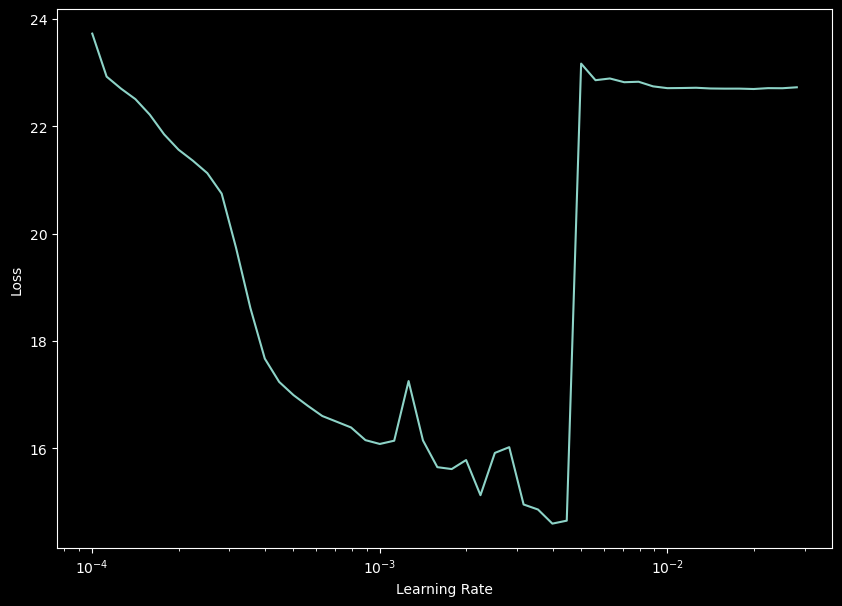

In [43]:
lrs = 1e-4 * (10 ** (np.arange(50)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [44]:
minimum = min(history.history['loss'])
index = history.history['loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.003981071705534973


# Training my model

In [45]:
model_lstm = ResidualWrapper(
    Sequential([
        
        Conv1D(64, kernel_size=(3,), activation='relu', padding='same'),
        MaxPooling1D(2, strides=1, padding='same'),
        
        Bidirectional(LSTM(32, return_sequences=True)),
        Bidirectional(LSTM(32, return_sequences=True)),
        
        # ▼ For Single Shot Model
        #LSTM(32, return_sequences=False),
        Dense(2048, activation='relu'),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dense(128, activation='relu'),

        Dense(n_features),
        # ▼ For Single Shot Model
        #Dense(lags*n_features, kernel_initializer=tf.initializers.zeros()),
        #Reshape([lags, n_features])
    ])
)

history = compile_and_fit(model_lstm, multi_window, max_epochs=50, patience=4, lr=lr)

Epoch 1/50
12/12 [==============================] - 12s 257ms/step - loss: 23.3262 - smape: 23.2565 - val_loss: 52.4226 - val_smape: 52.4226
Epoch 2/50
12/12 [==============================] - 2s 127ms/step - loss: 22.5739 - smape: 22.5017 - val_loss: 52.2976 - val_smape: 52.2976
Epoch 3/50
12/12 [==============================] - 2s 128ms/step - loss: 22.4002 - smape: 22.3752 - val_loss: 51.9771 - val_smape: 51.9771
Epoch 4/50
12/12 [==============================] - 2s 127ms/step - loss: 21.9147 - smape: 21.9496 - val_loss: 50.9834 - val_smape: 50.9834
Epoch 5/50
12/12 [==============================] - 2s 124ms/step - loss: 21.5078 - smape: 21.5154 - val_loss: 50.4544 - val_smape: 50.4544
Epoch 6/50
12/12 [==============================] - 2s 129ms/step - loss: 21.1769 - smape: 21.2019 - val_loss: 50.1814 - val_smape: 50.1814
Epoch 7/50
12/12 [==============================] - 2s 125ms/step - loss: 20.6174 - smape: 20.6302 - val_loss: 48.8800 - val_smape: 48.8800
Epoch 8/50
12/12 [=

# Calculate SMAPE metric for validation set

In [46]:
predictions_val = model_lstm.predict(multi_window.val)[0]
predictions_val = inverse_transform(predictions_val, pow_labels)
predictions_val = inverse_transform(predictions_val, mms_labels)
predictions_val = inverse_transform(predictions_val, stds_labels)

true_val = inverse_transform(val_df.iloc[1:-1][label_columns], pow_labels)
true_val = inverse_transform(true_val, mms_labels)
true_val = inverse_transform(true_val, stds_labels)

smape(tf.convert_to_tensor(np.array(true_val).astype('float32')), np.round(predictions_val).astype('float32'))

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(), dtype=float32, numpy=6.9951267>

## Plotting some forecasting with my window slicer

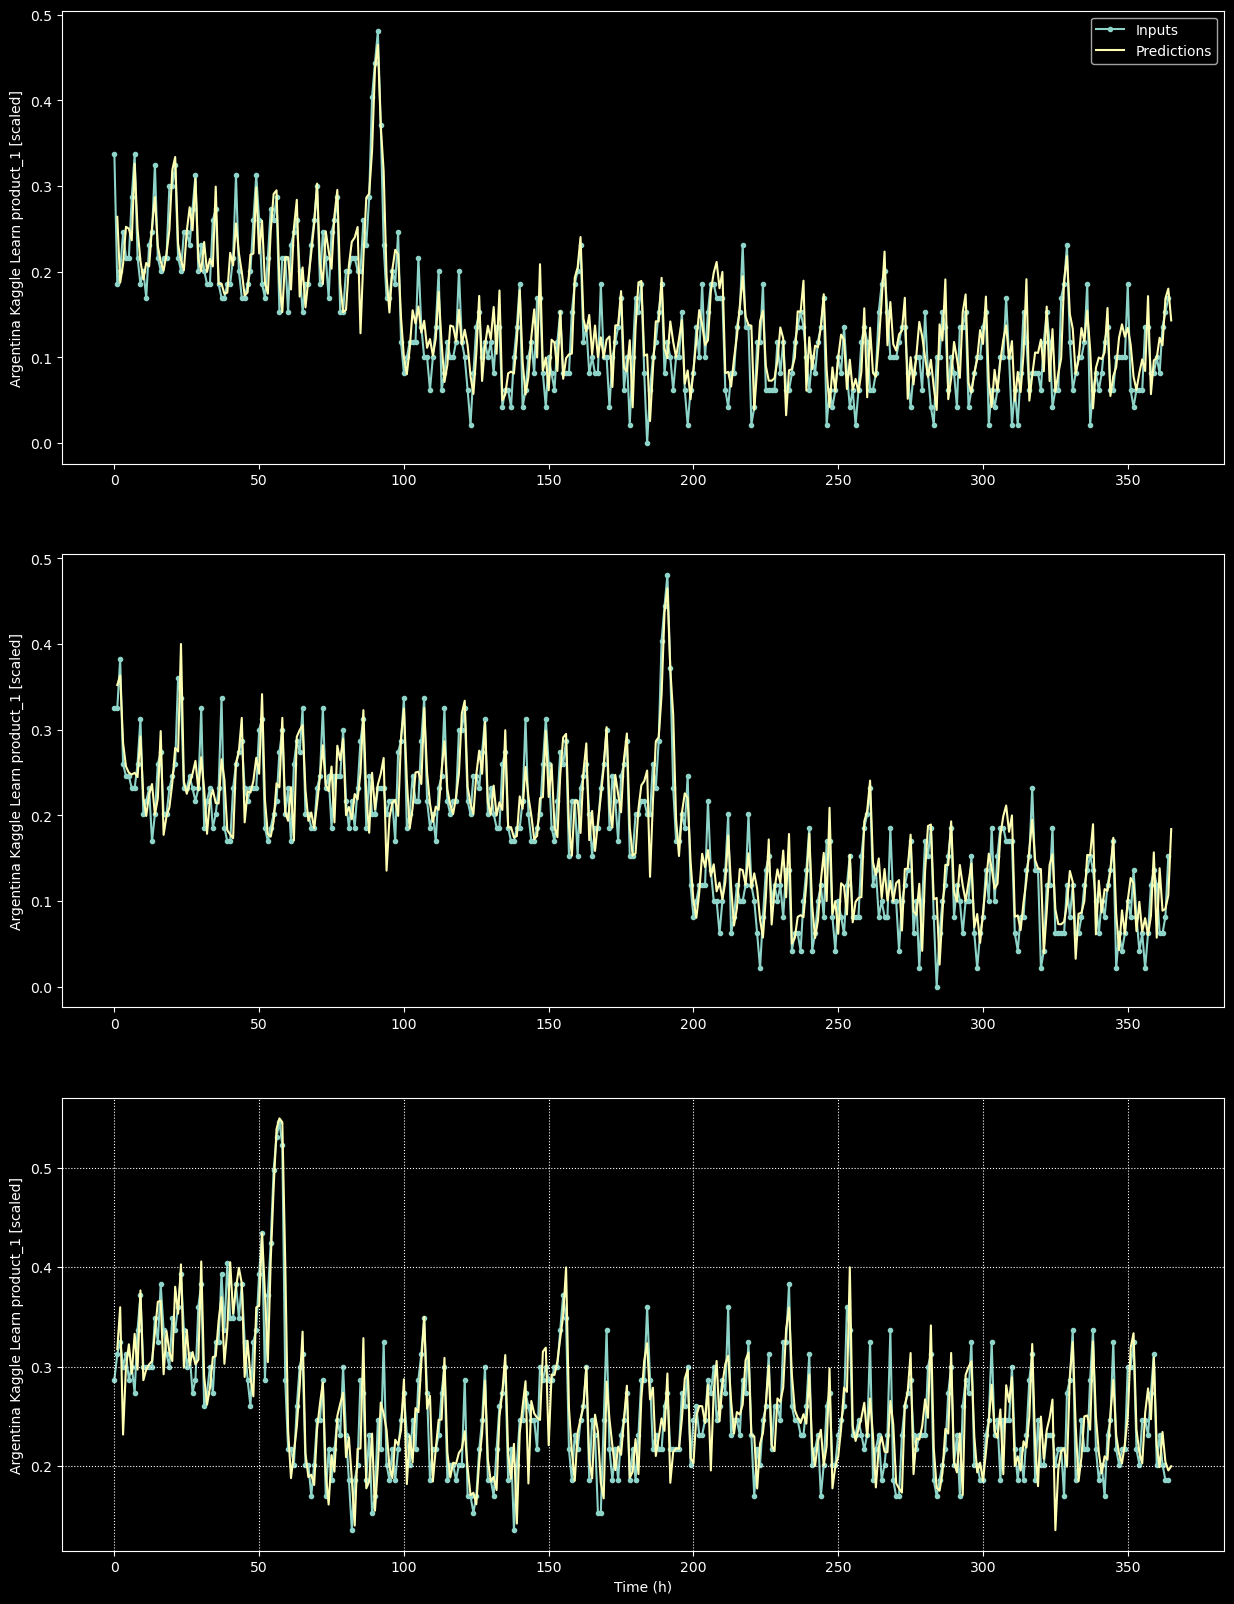

In [47]:
multi_window.plot(model_lstm, plot_col=label_columns[1])

# Forecasting values to 2022 year

1/1 [==============================] - 0s 242ms/step


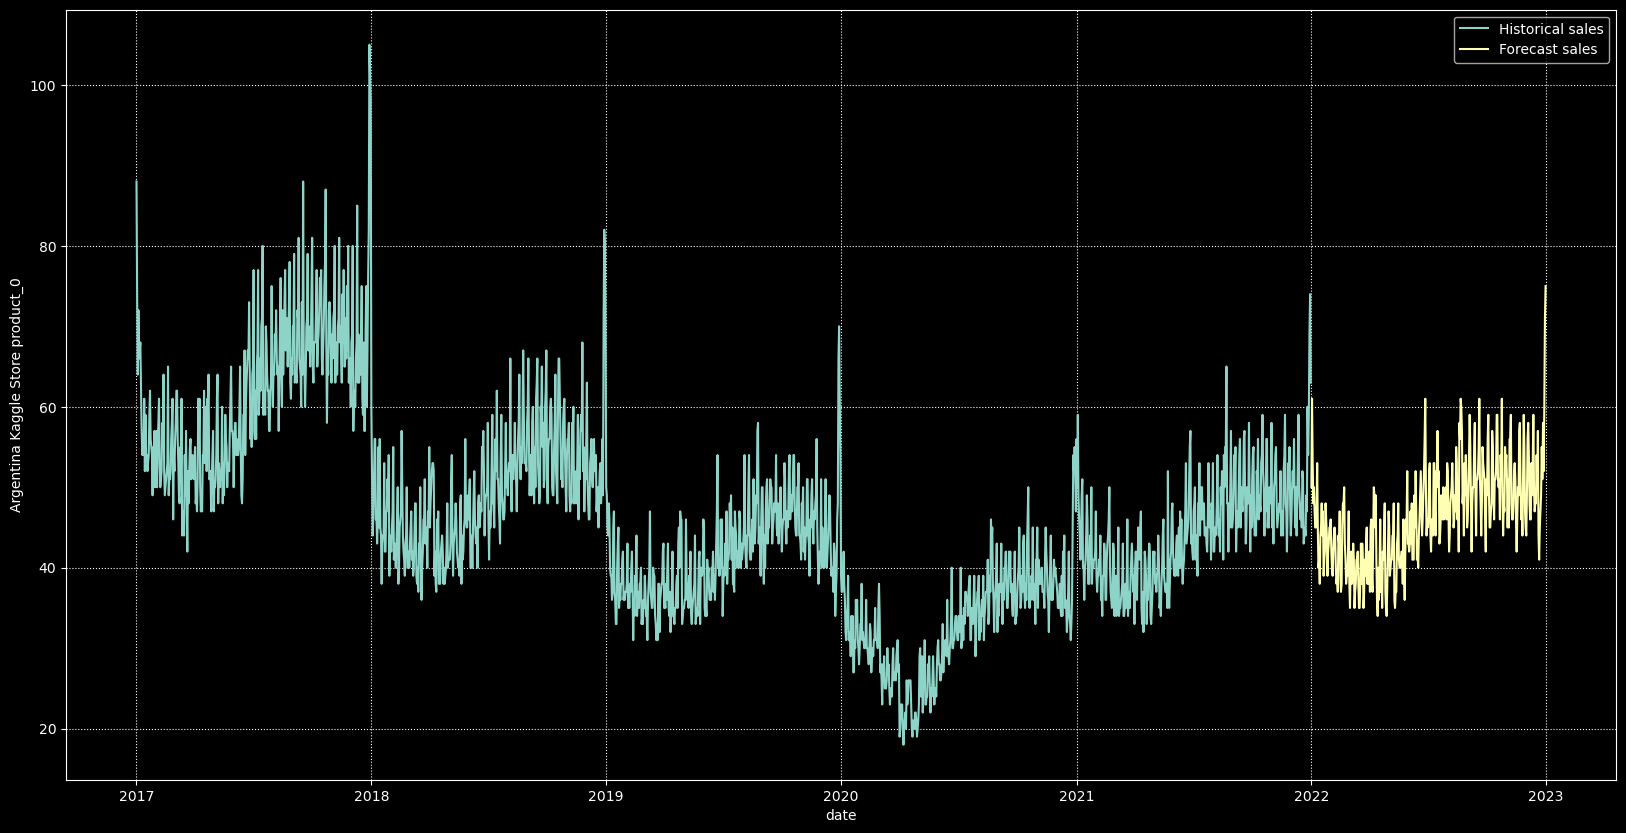

In [48]:
predictions = model_lstm.predict(multi_window.test)[0]
predictions = inverse_transform(predictions, pow_labels)
predictions = inverse_transform(predictions, mms_labels)
predictions = inverse_transform(predictions, stds_labels)

i=5
plt.figure(figsize=(20,10))
plt.plot(df_byDate[df_byDate.date.dt.year <= 2021].date.values, np.array(df_byDate[label_columns[i]]), label="Historical sales")
plt.plot(pd.date_range("2022-01-01", "2022-12-31"), np.round(predictions[:, i]).astype('int32'), label="Forecast sales")
plt.legend()
plt.xlabel("date")
plt.ylabel(label_columns[i])
plt.grid(linestyle=":")

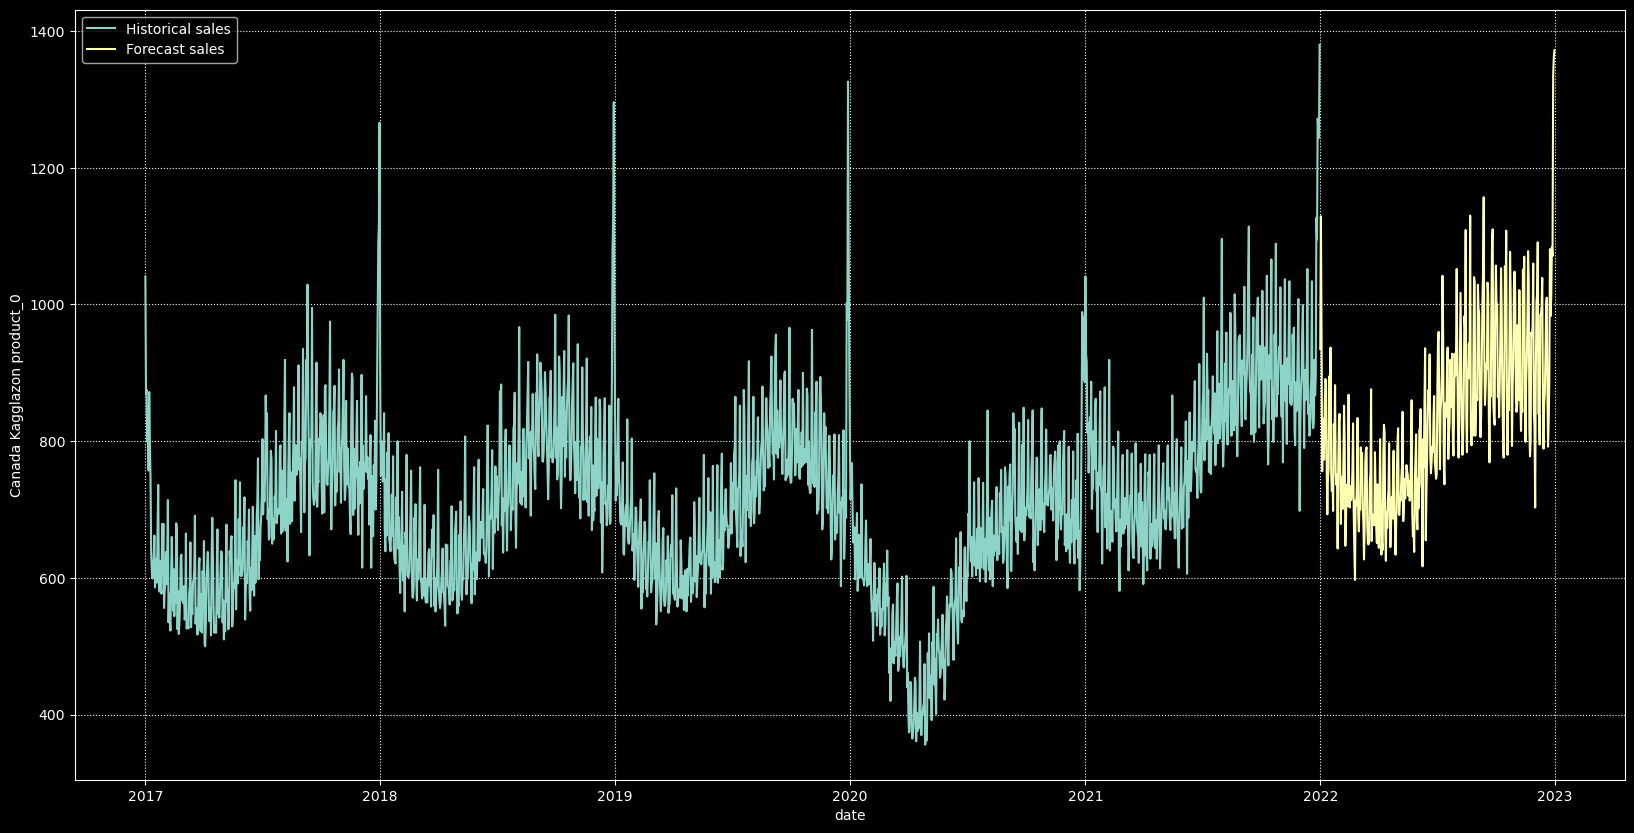

In [49]:
i=25
plt.figure(figsize=(20,10))
plt.plot(df_byDate[df_byDate.date.dt.year <= 2021].date.values, np.array(df_byDate[label_columns[i]]), label="Historical sales")
plt.plot(pd.date_range("2022-01-01", "2022-12-31"), np.round(predictions[:, i]).astype('int32'), label="Forecast sales")
plt.legend()
plt.xlabel("date")
plt.ylabel(label_columns[i])
plt.grid(linestyle=":")

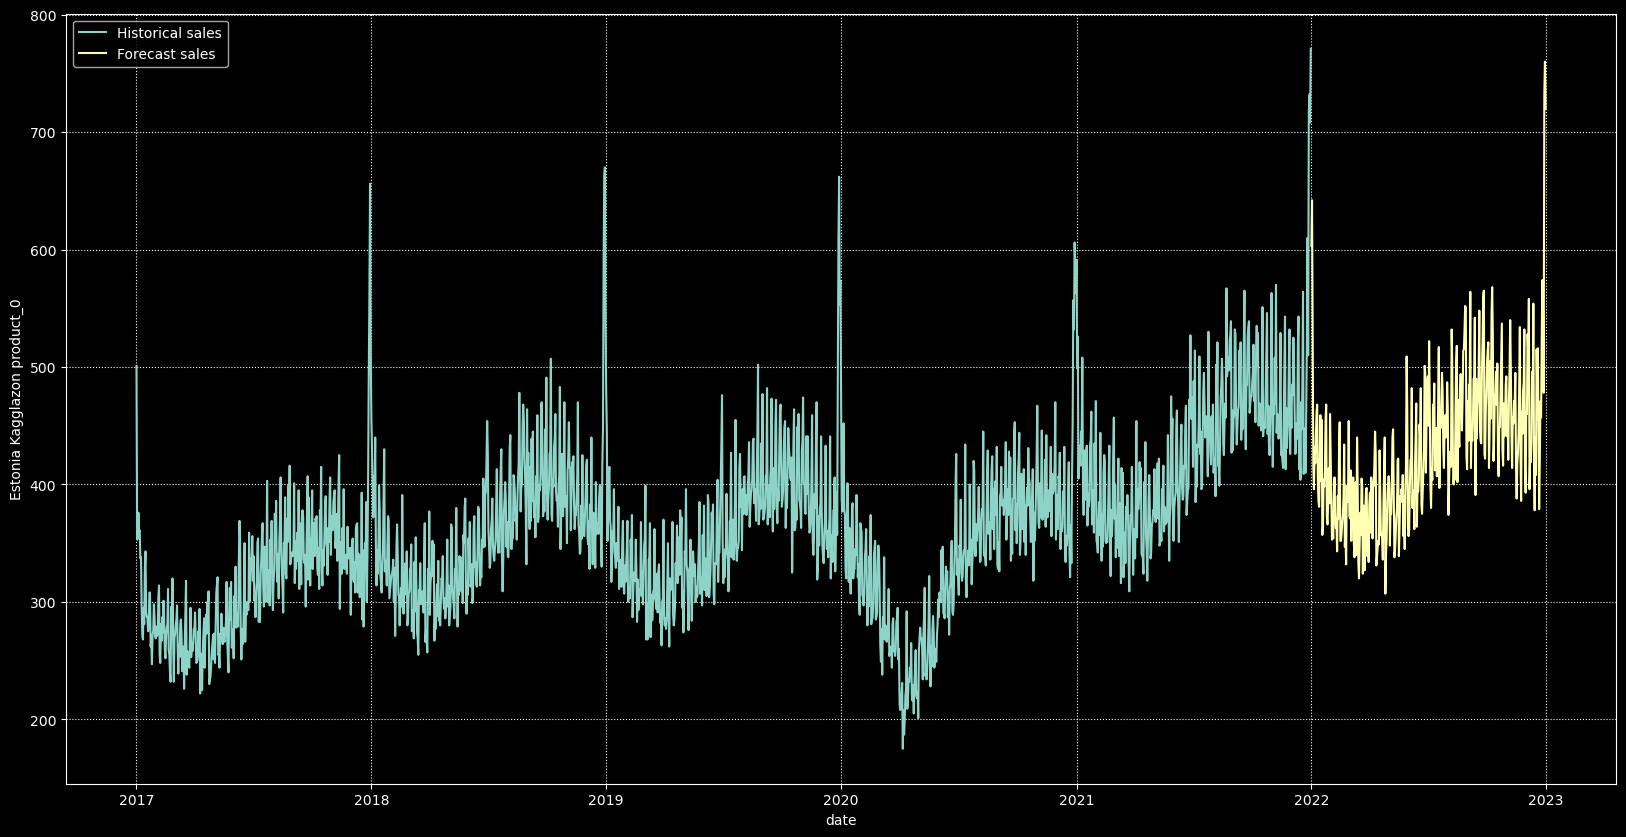

In [50]:
i=40
plt.figure(figsize=(20,10))
plt.plot(df_byDate[df_byDate.date.dt.year <= 2021].date.values, np.array(df_byDate[label_columns[i]]), label="Historical sales")
plt.plot(pd.date_range("2022-01-01", "2022-12-31"), np.round(predictions[:, i]).astype('int32'), label="Forecast sales")
plt.legend()
plt.xlabel("date")
plt.ylabel(label_columns[i])
plt.grid(linestyle=":")

## Making submission file

In [51]:
df_test["num_sold"] = 0
k = 0
for country in countries:
    for store in stores:
        for product in products:
            df_test.loc[(df_test["country"] == country) & (df_test["store"] == store) & (df_test["product"] == product), "num_sold"] = np.round(predictions[:, k]).astype('int32')
            k += 1
df_test

date    country         store  \
id                                           
136950 2022-01-01  Argentina  Kaggle Learn   
136951 2022-01-01  Argentina  Kaggle Learn   
136952 2022-01-01  Argentina  Kaggle Learn   
136953 2022-01-01  Argentina  Kaggle Learn   
136954 2022-01-01  Argentina  Kaggle Learn   
...           ...        ...           ...   
164320 2022-12-31      Spain     Kagglazon   
164321 2022-12-31      Spain     Kagglazon   
164322 2022-12-31      Spain     Kagglazon   
164323 2022-12-31      Spain     Kagglazon   
164324 2022-12-31      Spain     Kagglazon   

                                               product  num_sold  
id                                                                
136950               Using LLMs to Improve Your Coding        32  
136951                   Using LLMs to Train More LLMs        33  
136952  Using LLMs to Win Friends and Influence People         5  
136953      Using LLMs to Win More Kaggle Competitions        31  
136954                      Using LLMs to Write Better        23  
...                                                ...       ...  
164320               Using LLMs to Improve Your Coding       766  
164321                   Using LLMs to Train More LLMs       750  
164322  Using LLMs to Win Friends and Influence People       124  
164323      Using LLMs to Win More Kaggle Competitions       652  
164324                      Using LLMs to Write Better       539  

[27375 rows x 5 columns]

In [52]:
submission = df_test["num_sold"]
submission.to_csv("/kaggle/working/submission.csv")

In [53]:
pd.read_csv("/kaggle/working/submission.csv")

id  num_sold
0      136950        32
1      136951        33
2      136952         5
3      136953        31
4      136954        23
...       ...       ...
27370  164320       766
27371  164321       750
27372  164322       124
27373  164323       652
27374  164324       539

[27375 rows x 2 columns]

# Conclusion
This challenge was very interesting for me; I learned some new concepts about forecasting in time series. However, there are multiple methods for making forecasts for this problem type, maybe this not is the best method but it helped me to start in this area.